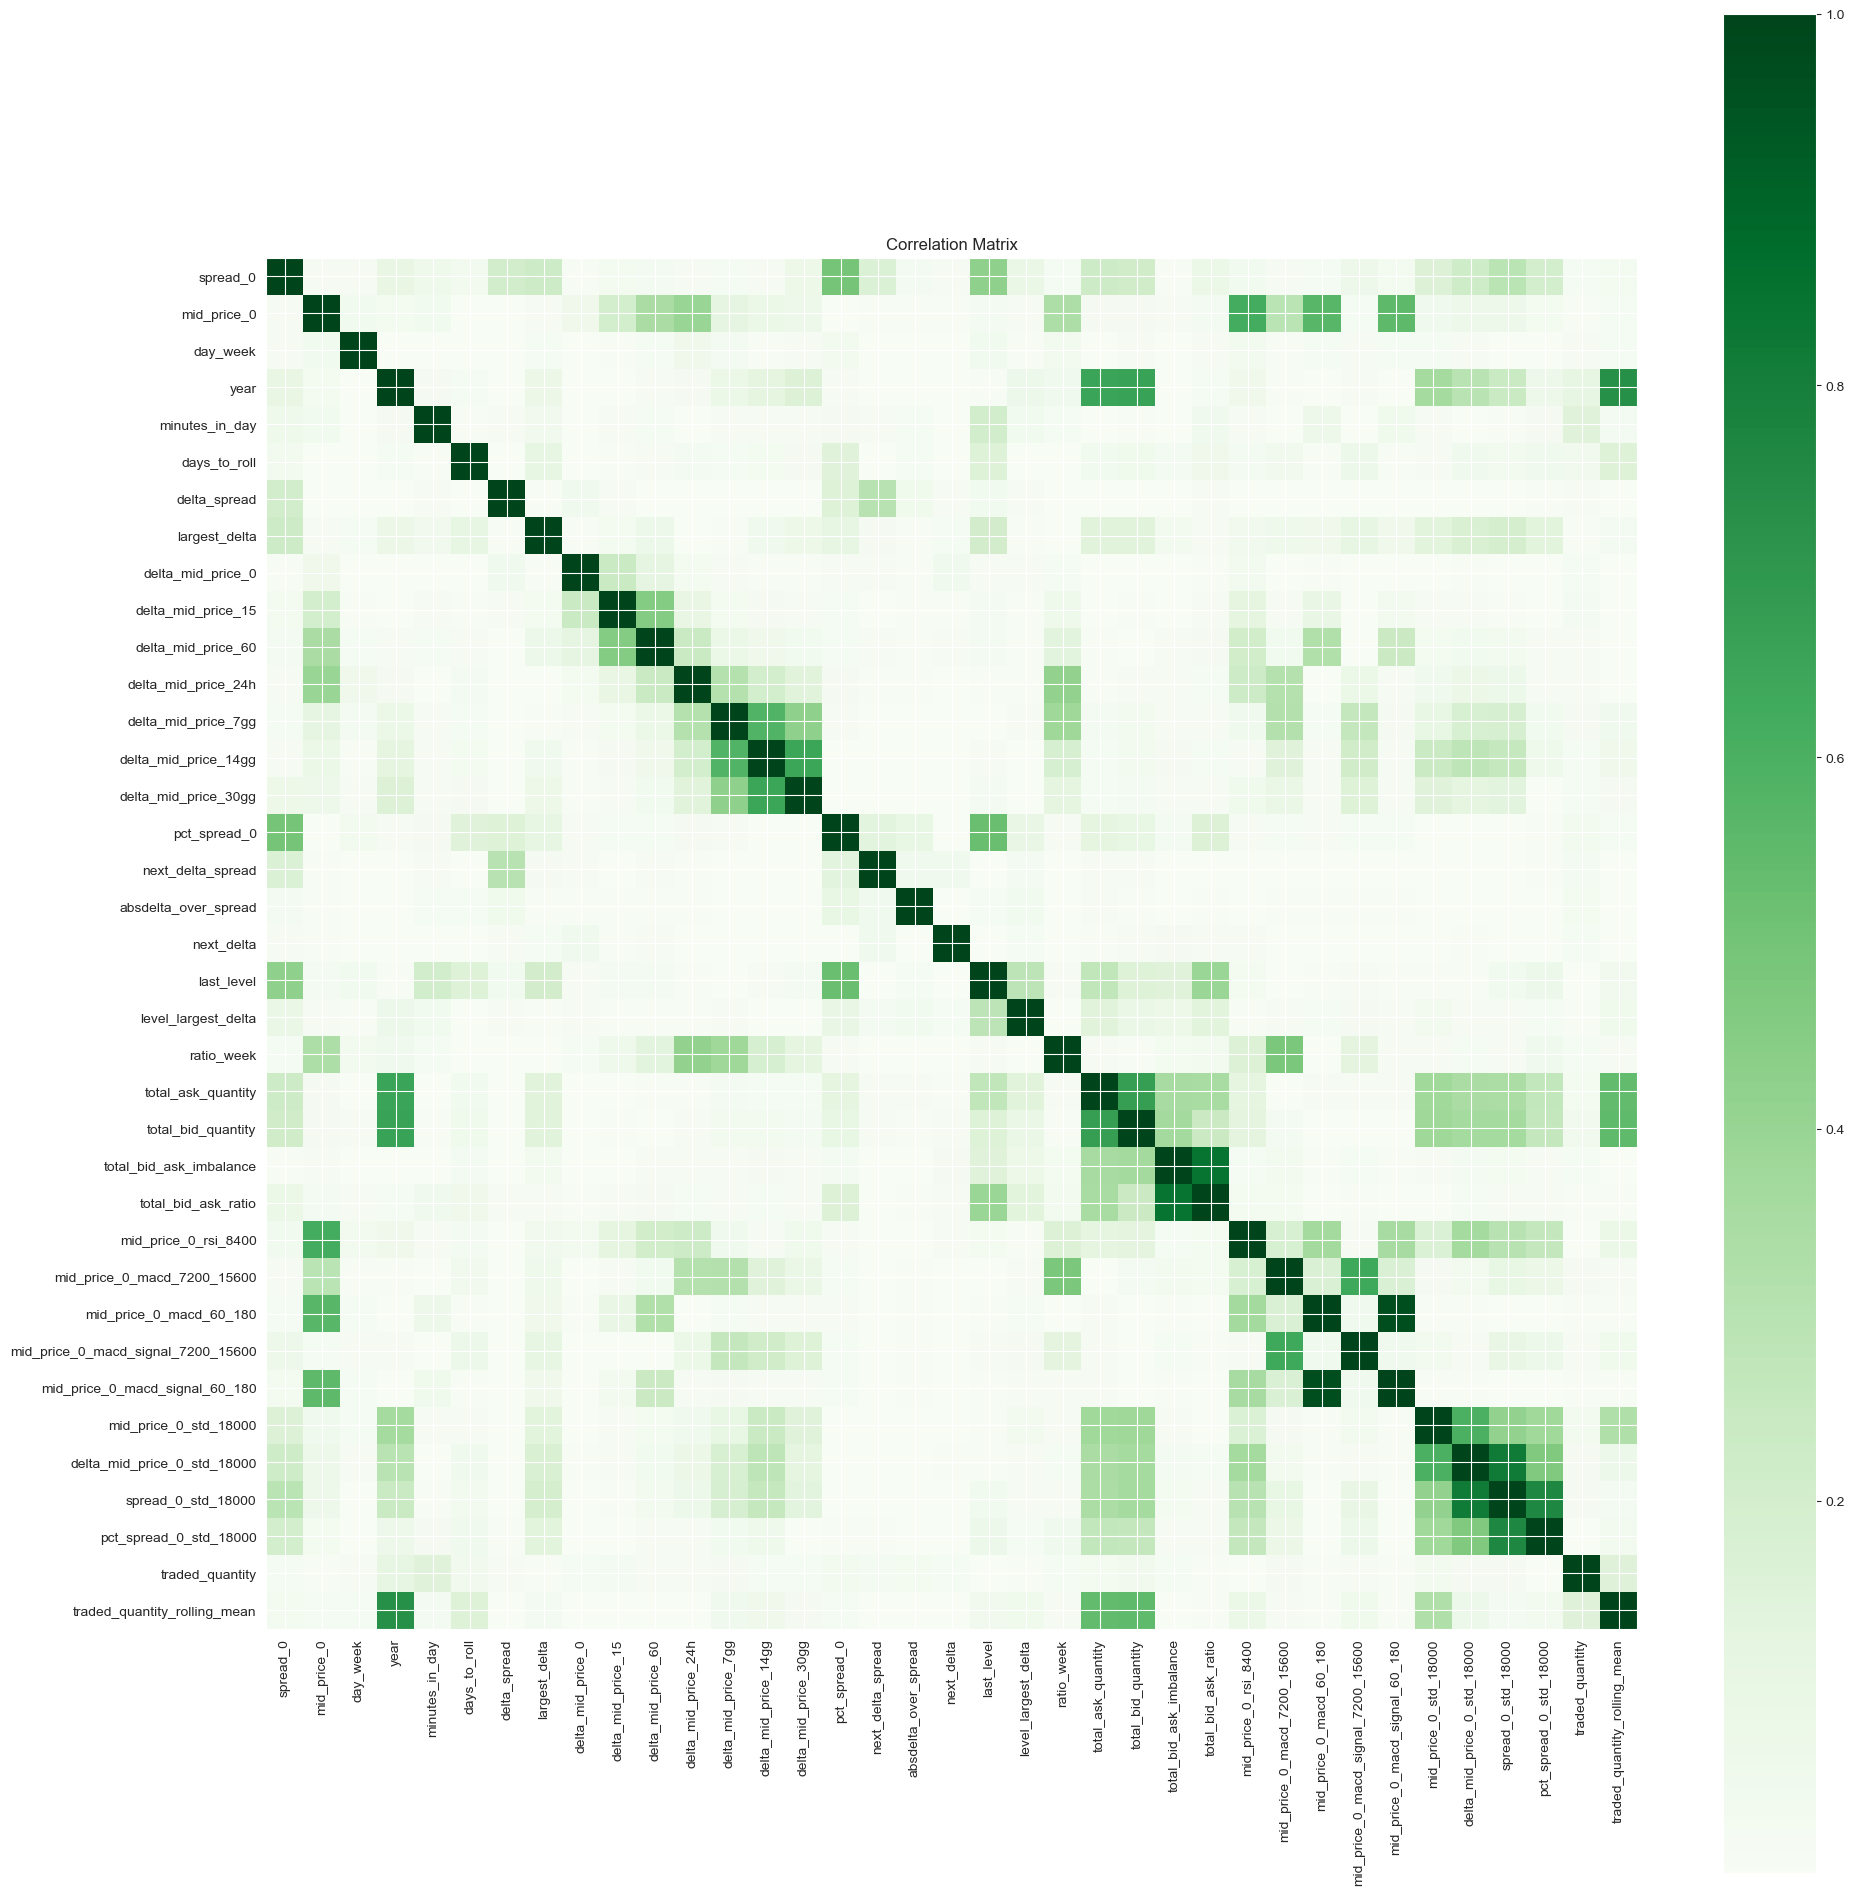

In [5]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from matplotlib.pyplot import GridSpec
import seaborn as sns
from datetime import datetime


parquet_path = "C:/Users/Riccardo/Documents/TTF_all/TTF_M1/train.parquet"
df = pl.read_parquet(parquet_path).drop('next_spread')
df2 = df.select([col for col in df.columns if col not in ['timestamp', 'prod']])
corr_matrix = df2.corr()
corr_matrix = corr_matrix.select(pl.col(corr_matrix.columns).abs())

plt.figure(figsize=(20, 20))
plt.imshow(corr_matrix, interpolation='nearest', cmap='Greens')
plt.colorbar()

num_cols = corr_matrix.columns
ticks = np.arange(len(num_cols))
plt.xticks(ticks, num_cols, rotation=90)
plt.yticks(ticks, num_cols)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

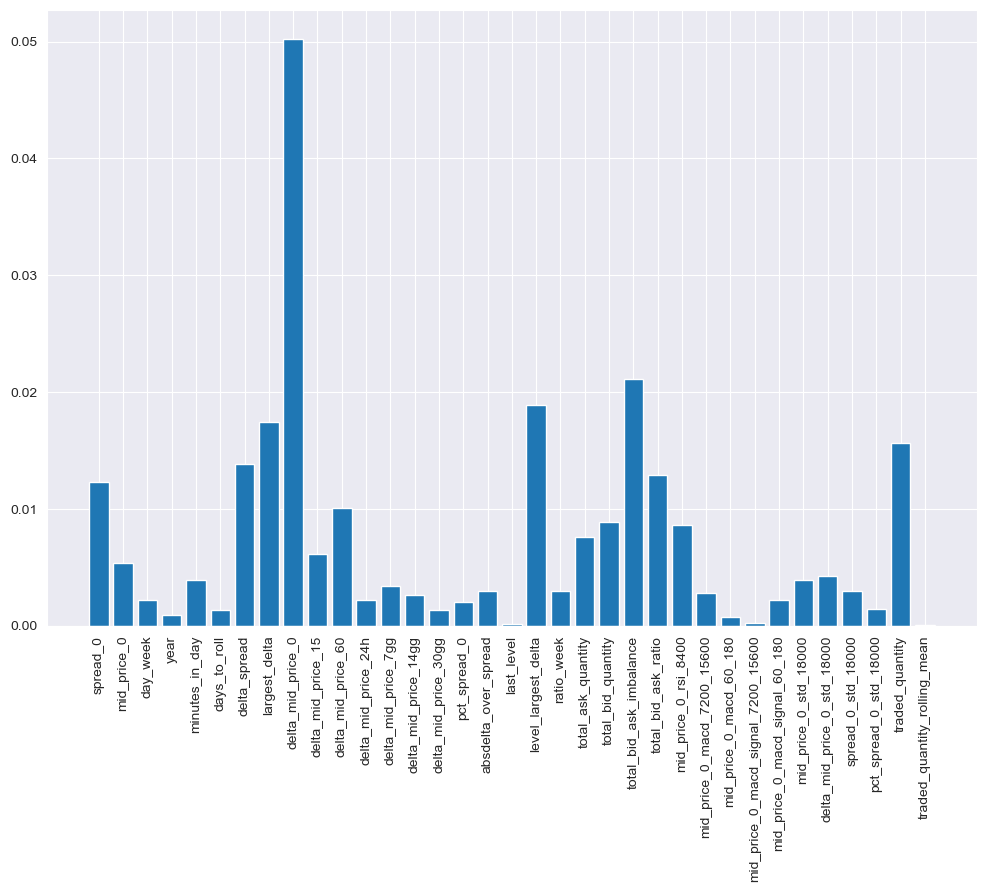

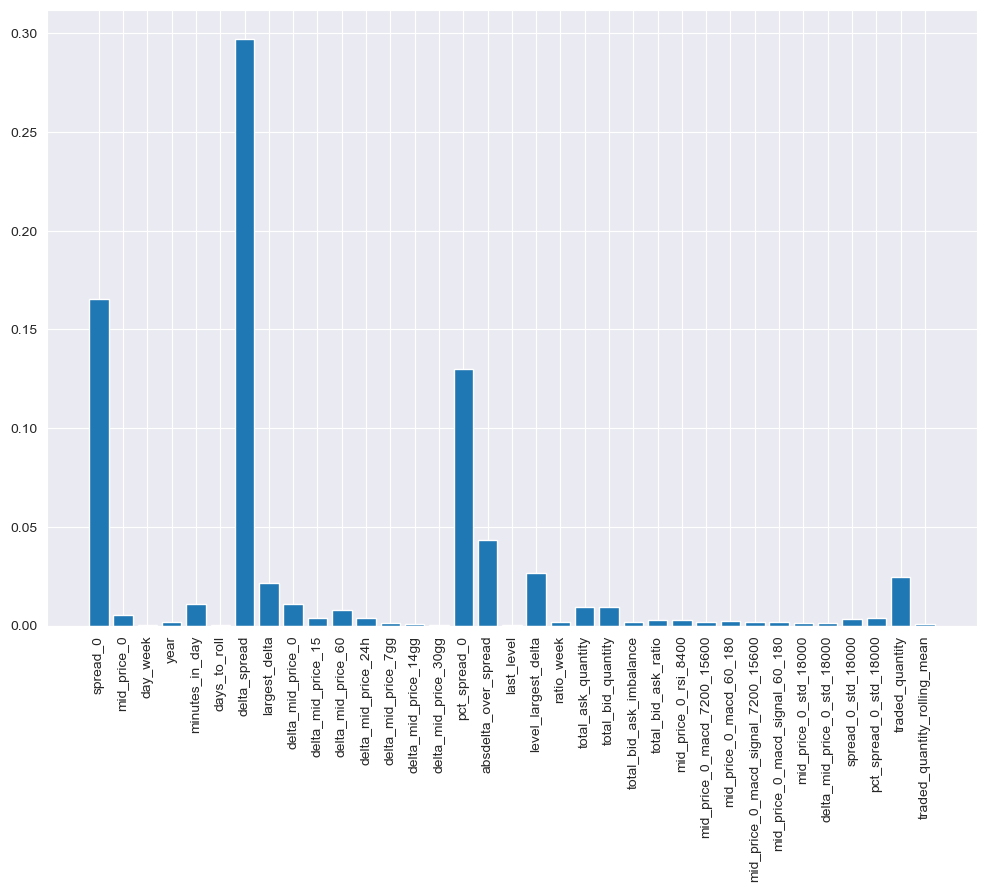

In [8]:
next_delta_corr = corr_matrix.select(pl.col('next_delta'))['next_delta'].to_list()
next_spread_corr = corr_matrix.select(pl.col('next_delta_spread'))['next_delta_spread'].to_list()
next_delta_index = df2.columns.index('next_delta')
next_spread_index = df2.columns.index('next_delta_spread')
if next_delta_index < next_spread_index:
    next_spread_index -= 1
else:
    next_delta_index -= 1
next_delta_corr.pop(next_spread_index)
next_delta_corr.pop(next_delta_index)
next_spread_corr.pop(next_spread_index)
next_spread_corr.pop(next_delta_index)


y_columns = ['next_delta', 'next_delta_spread']
x_columns = [col for col in df2.columns if col not in y_columns]

plt.figure(figsize=(12,8))
plt.bar(x_columns, next_delta_corr)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12,8))
plt.bar(x_columns, next_spread_corr)
plt.xticks(rotation=90)
plt.show()


Evaluating spread_class
Accuracy: 0.656

Confusion matrix:
 [[13499  6845  4511]
 [ 5177 41208  5185]
 [ 5398  7819 11888]]


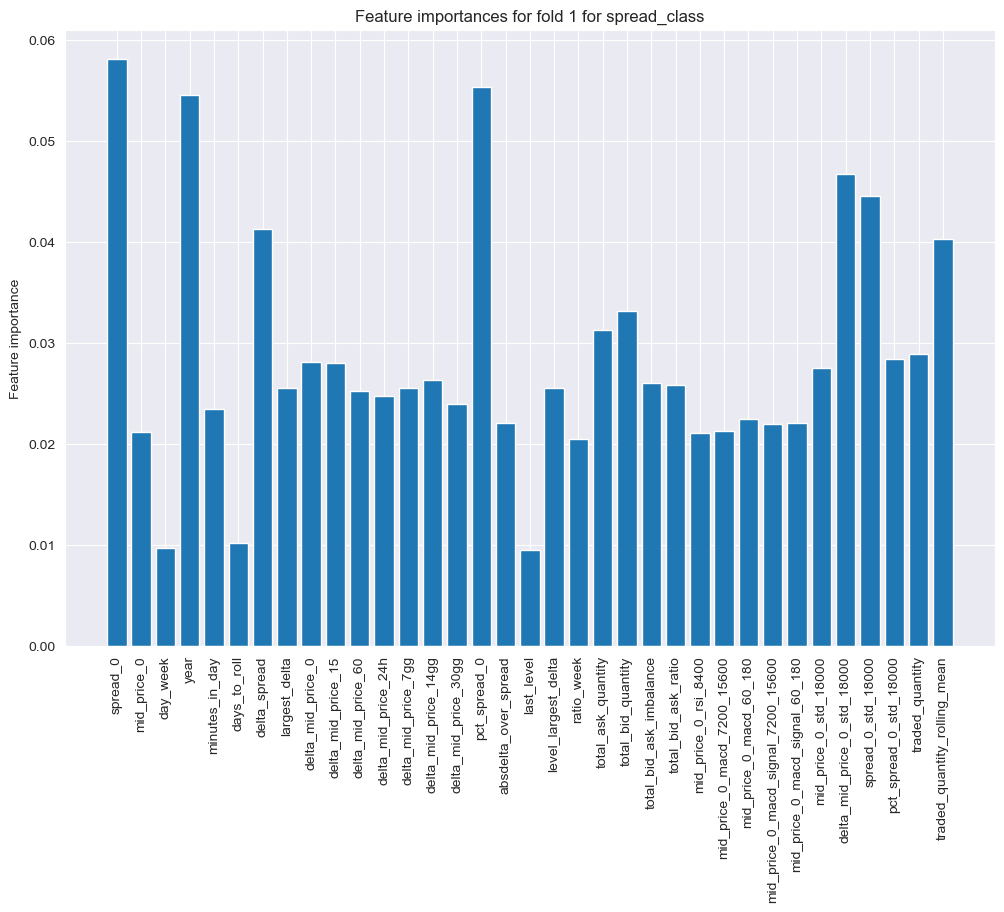

---------------------------------------------------
Accuracy: 0.659

Confusion matrix:
 [[13555  6676  4405]
 [ 5230 41473  4871]
 [ 5470  7988 11862]]


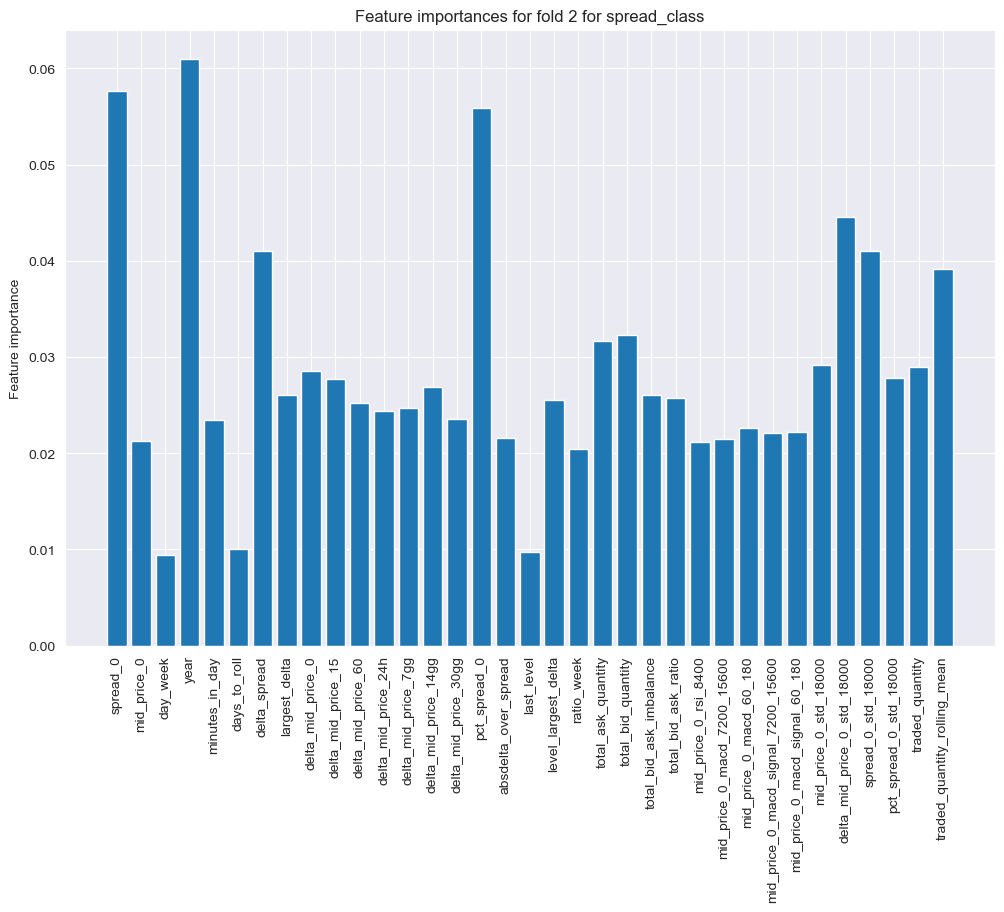

---------------------------------------------------
Accuracy: 0.655

Confusion matrix:
 [[13453  7014  4487]
 [ 5216 41164  5062]
 [ 5339  7948 11847]]


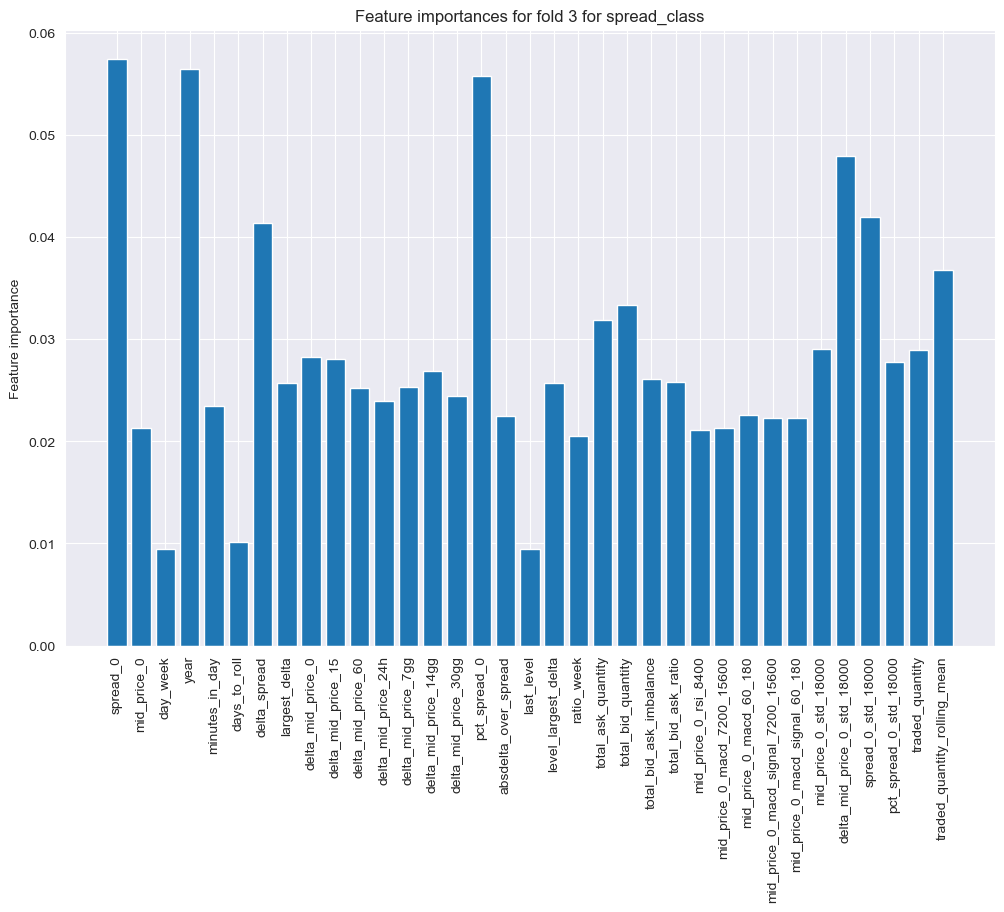

---------------------------------------------------
Accuracy: 0.657

Confusion matrix:
 [[13681  6766  4413]
 [ 5281 41329  4853]
 [ 5537  7968 11702]]


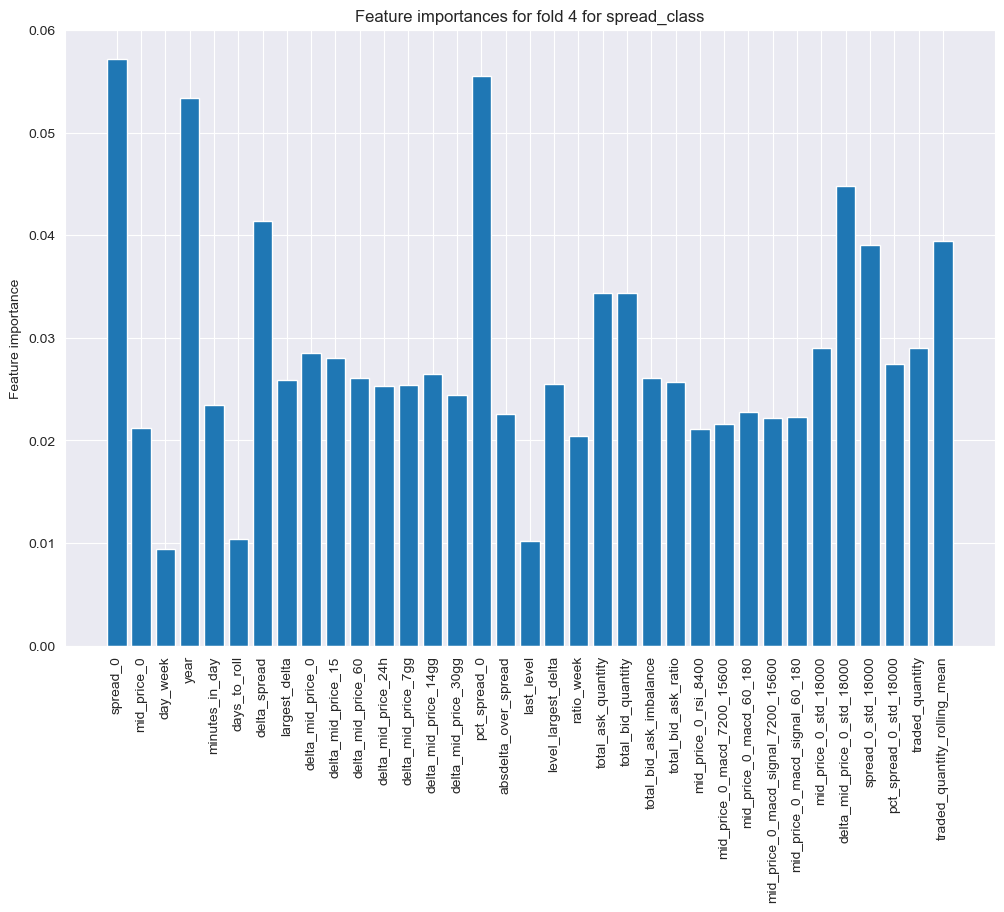

---------------------------------------------------
Accuracy: 0.656

Confusion matrix:
 [[13553  6687  4499]
 [ 5215 41331  5072]
 [ 5554  7933 11686]]


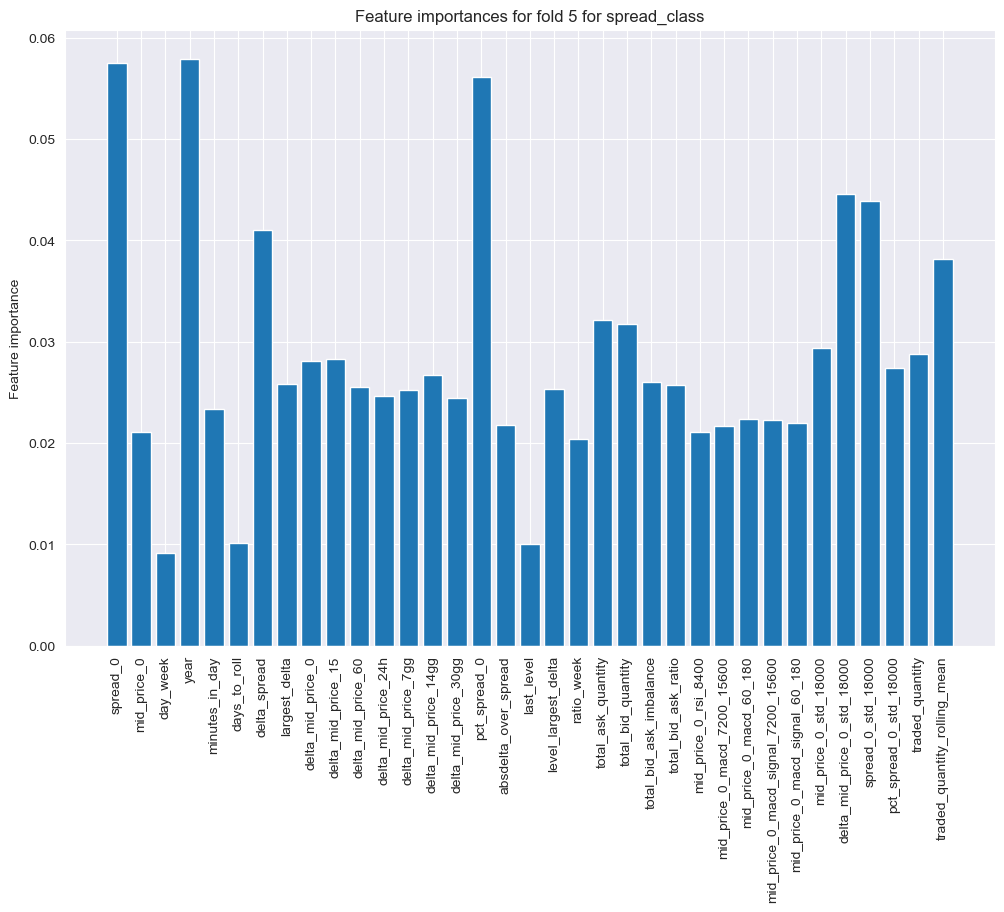

---------------------------------------------------
CV Accuracy delta(mean ± std over 5 folds): 0.656 ± 0.001


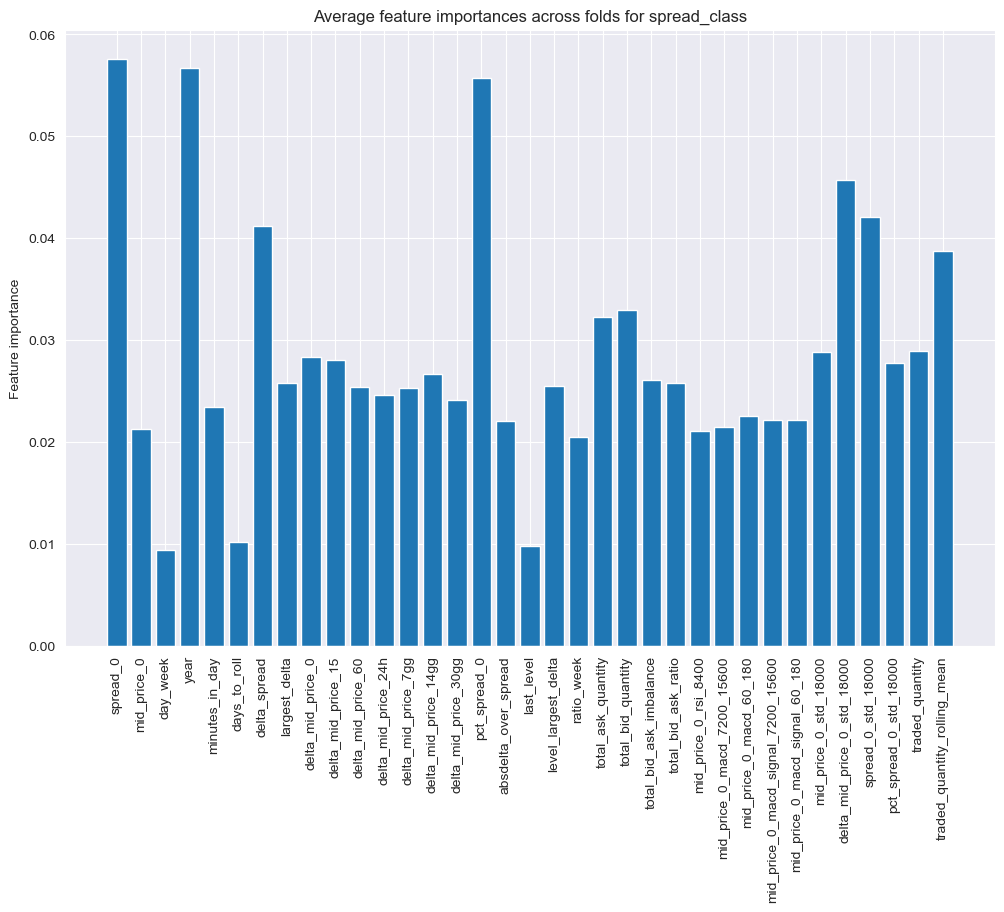

In [10]:
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

p25_delta, p75_delta, p25_spread, p75_spread = df2.select([
    pl.col("next_delta").quantile(0.25).alias("d25"),
    pl.col("next_delta").quantile(0.75).alias("d75"),
    pl.col("next_delta_spread").quantile(0.25).alias("s25"),
    pl.col("next_delta_spread").quantile(0.75).alias("s75")
]).row(0)

df2 = df2.with_columns([
    pl.when(pl.col("next_delta") < p25_delta).then(0)
      .when(pl.col("next_delta") <= p75_delta).then(1)
      .otherwise(2)
      .alias("delta_class"),

    pl.when(pl.col("next_delta_spread") < p25_spread).then(0)
      .when(pl.col("next_delta_spread") <= p75_spread).then(1)
      .otherwise(2)
      .alias("spread_class")
])

X = df2.select(x_columns).to_numpy()

for target in ['spread_class']:
    print(f'Evaluating {target}')

    y = df2.select(target).to_numpy().flatten()

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_importances = []

    fold_idx = 1
    for train_idx, test_idx in kf.split(X):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf2 = ExtraTreesClassifier(n_estimators=100, random_state=42)
        clf2.fit(X_train, y_train)

        y_pred = clf2.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}\n")
        fold_accuracies.append(accuracy)


        cm = confusion_matrix(y_test, y_pred)
        print("Confusion matrix:\n", cm)

        importances = clf2.feature_importances_
        fold_importances.append(importances)

        plt.figure(figsize=(12, 8))
        plt.bar(x_columns, importances)
        plt.xticks(rotation=90)
        plt.ylabel("Feature importance")
        plt.title(f"Feature importances for fold {fold_idx} for {target}")
        plt.show()

        print("---------------------------------------------------")
        fold_idx += 1


    mean_acc = np.mean(fold_accuracies)
    std_acc  = np.std(fold_accuracies)
    print(f"CV Accuracy delta(mean ± std over {kf.n_splits} folds): {mean_acc:.3f} ± {std_acc:.3f}")

    fold_importances = np.array(fold_importances)
    avg_importances = fold_importances.mean(axis=0)

    plt.figure(figsize=(12, 8))
    plt.bar(x_columns, avg_importances)
    plt.xticks(rotation=90)
    plt.ylabel("Feature importance")
    plt.title(f"Average feature importances across folds for {target}")
    plt.show()




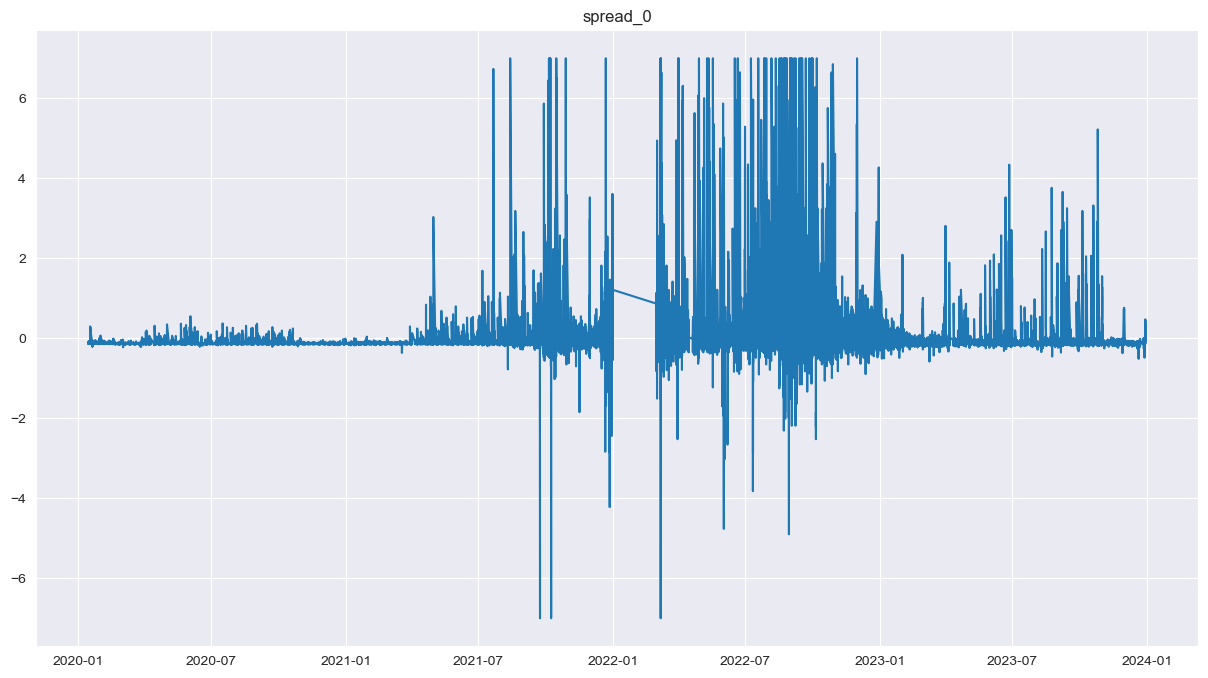

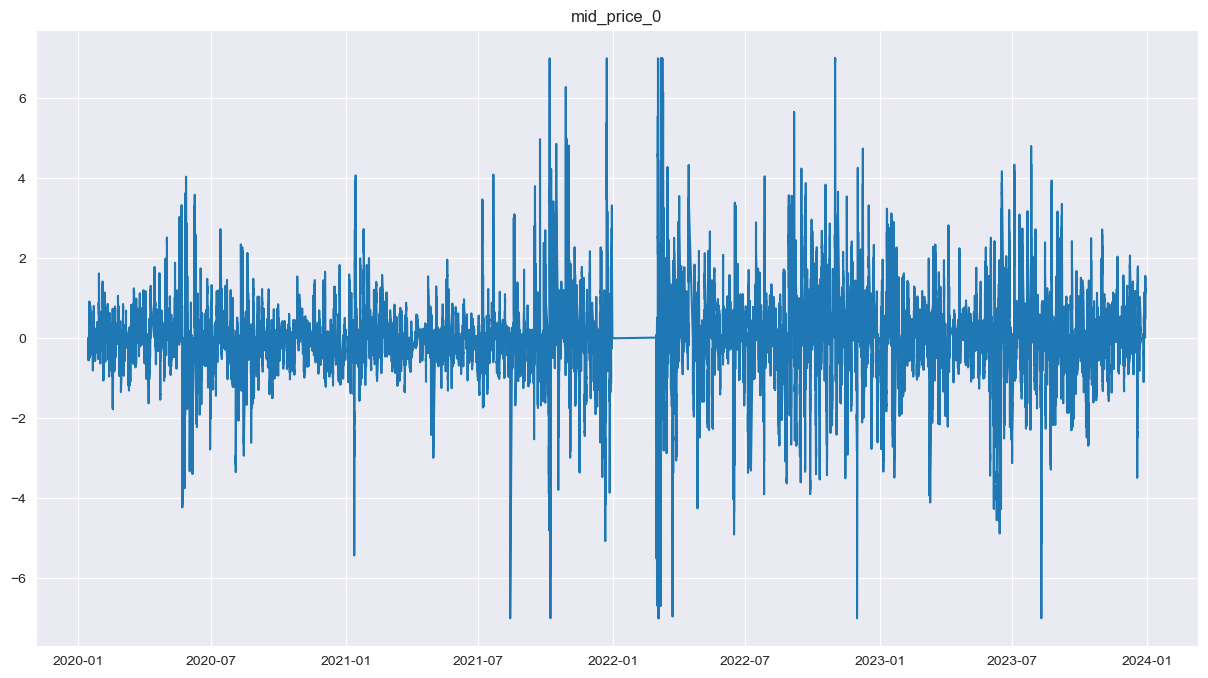

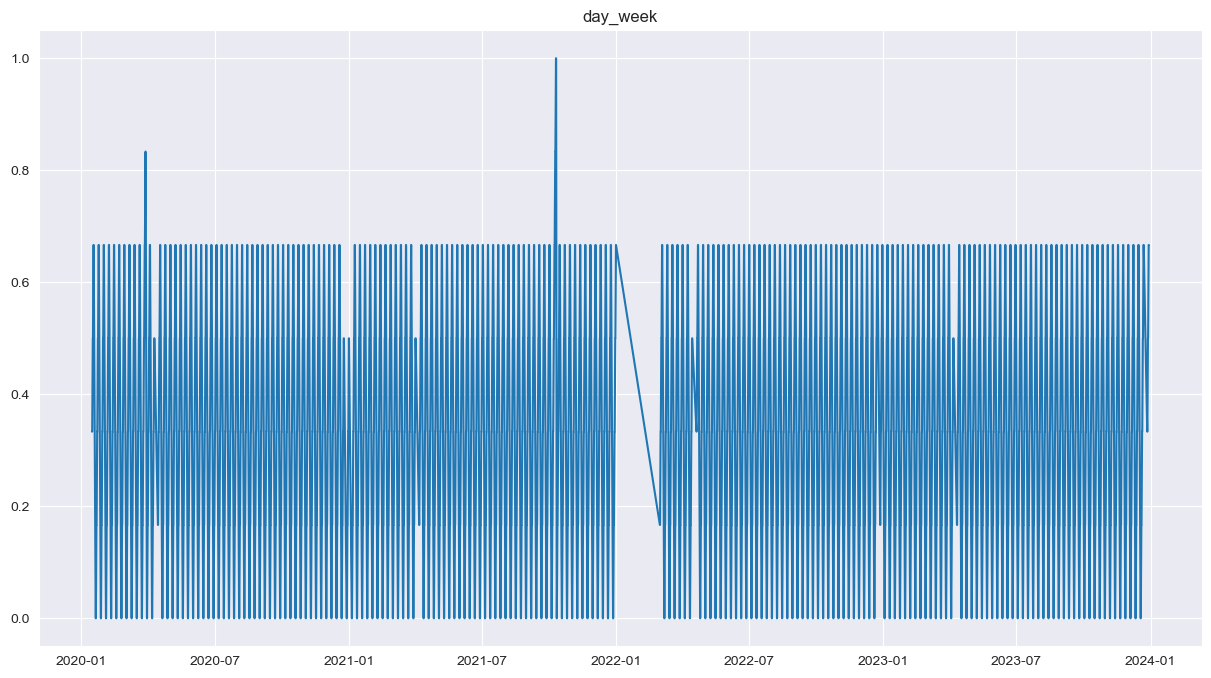

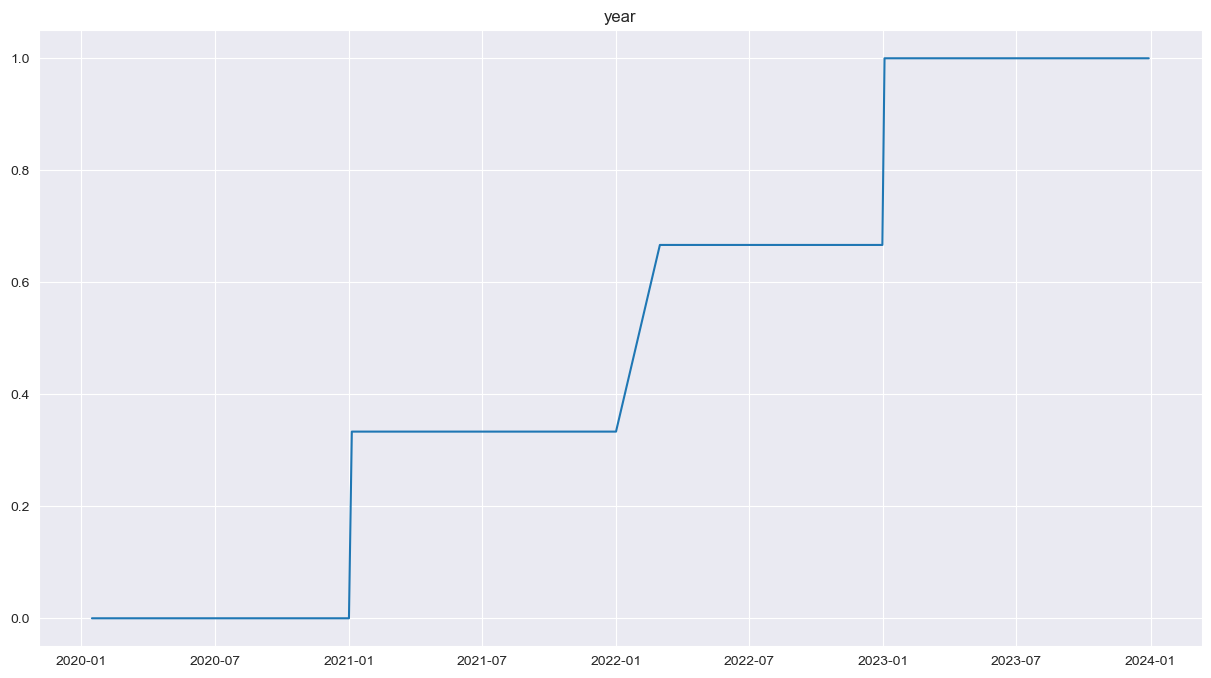

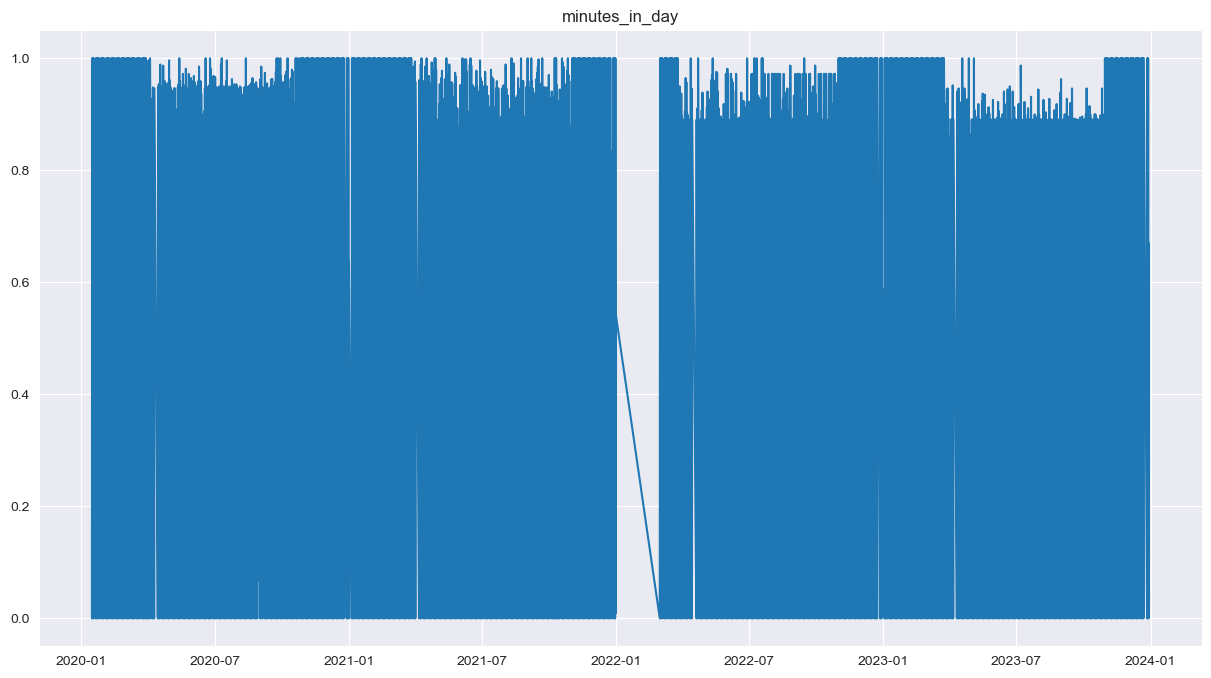

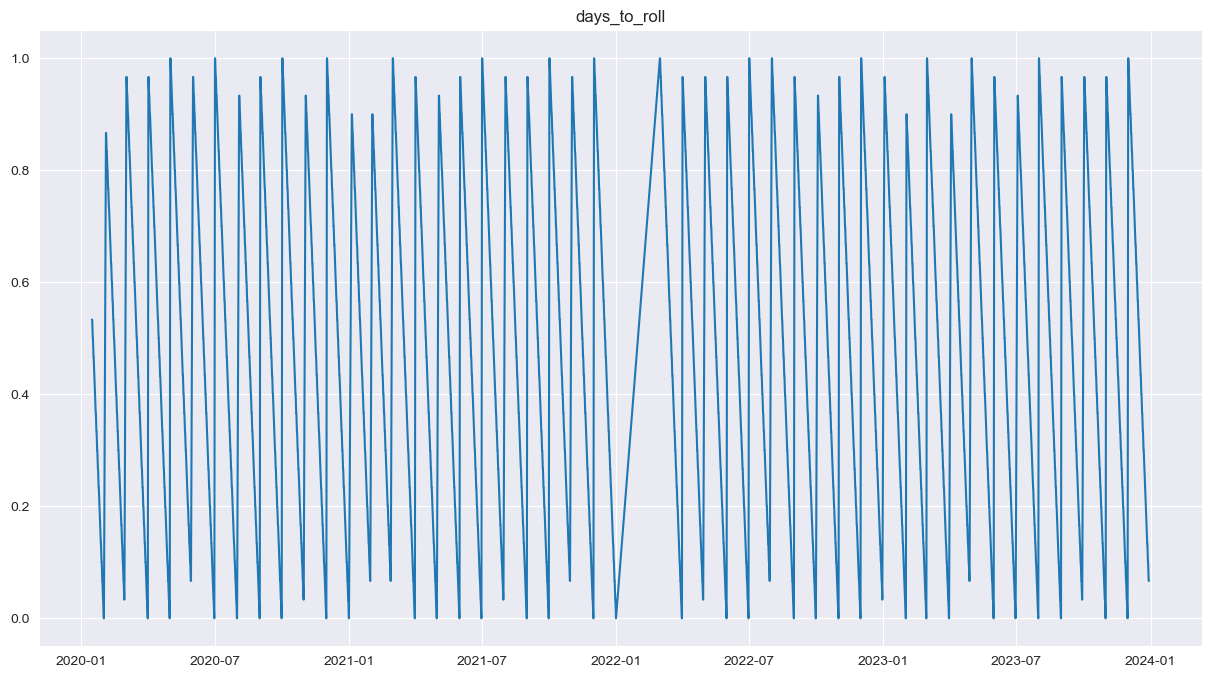

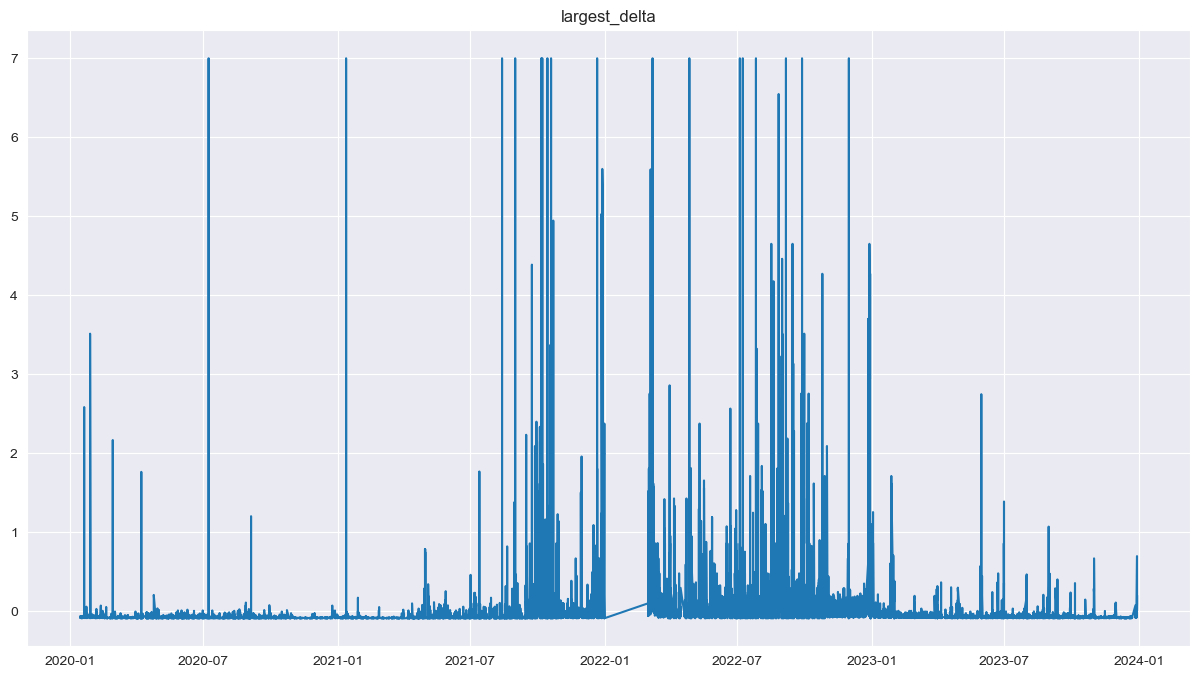

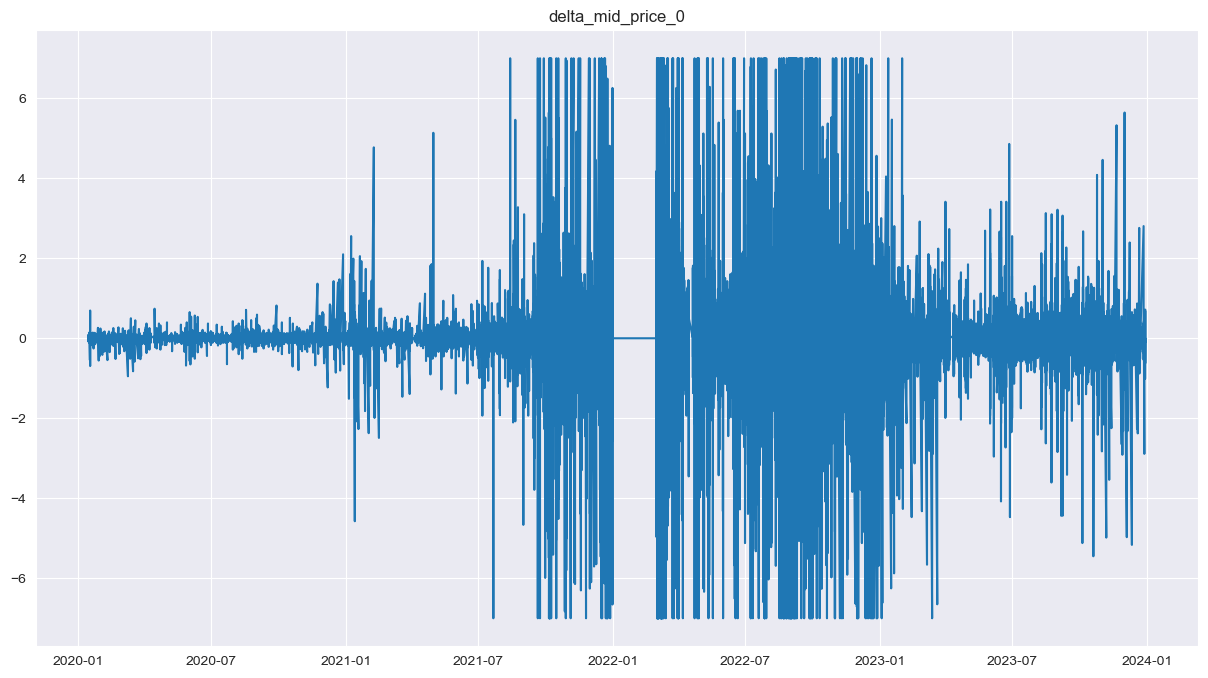

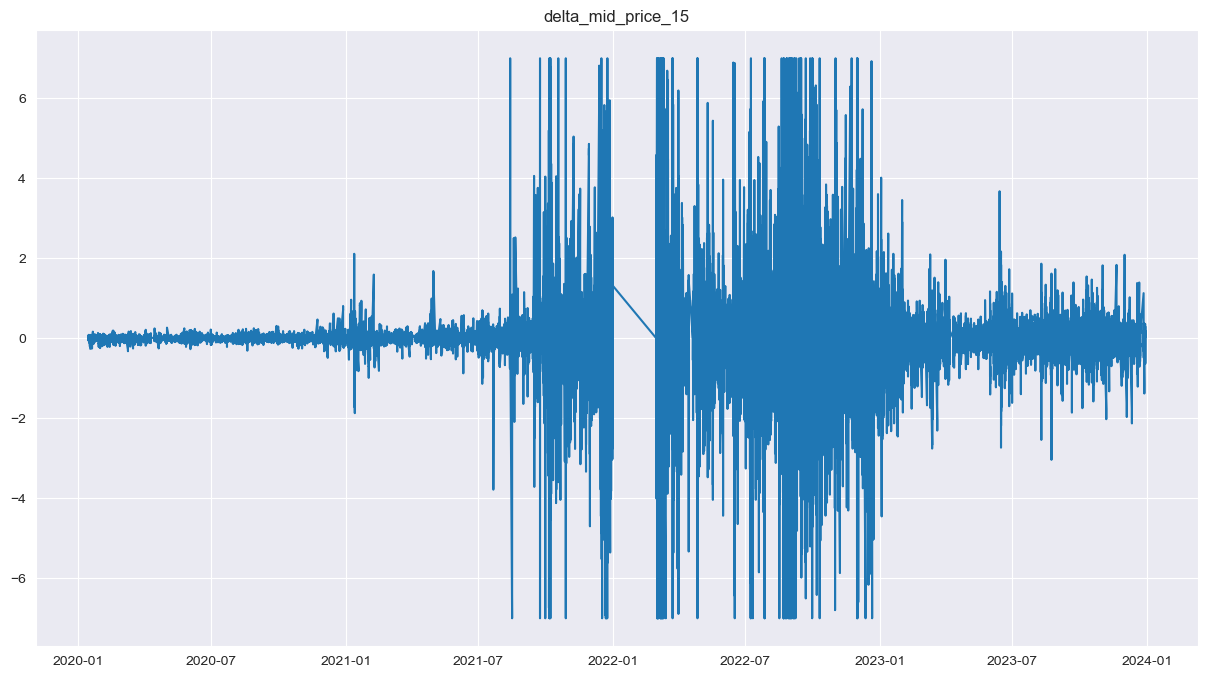

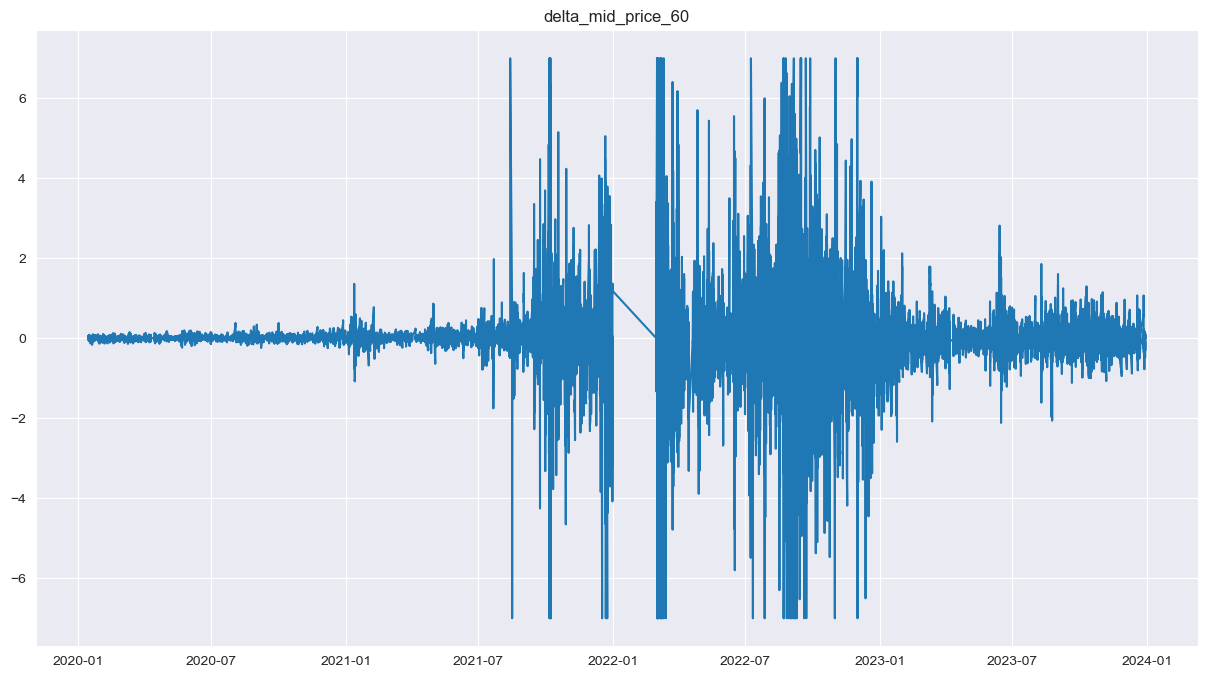

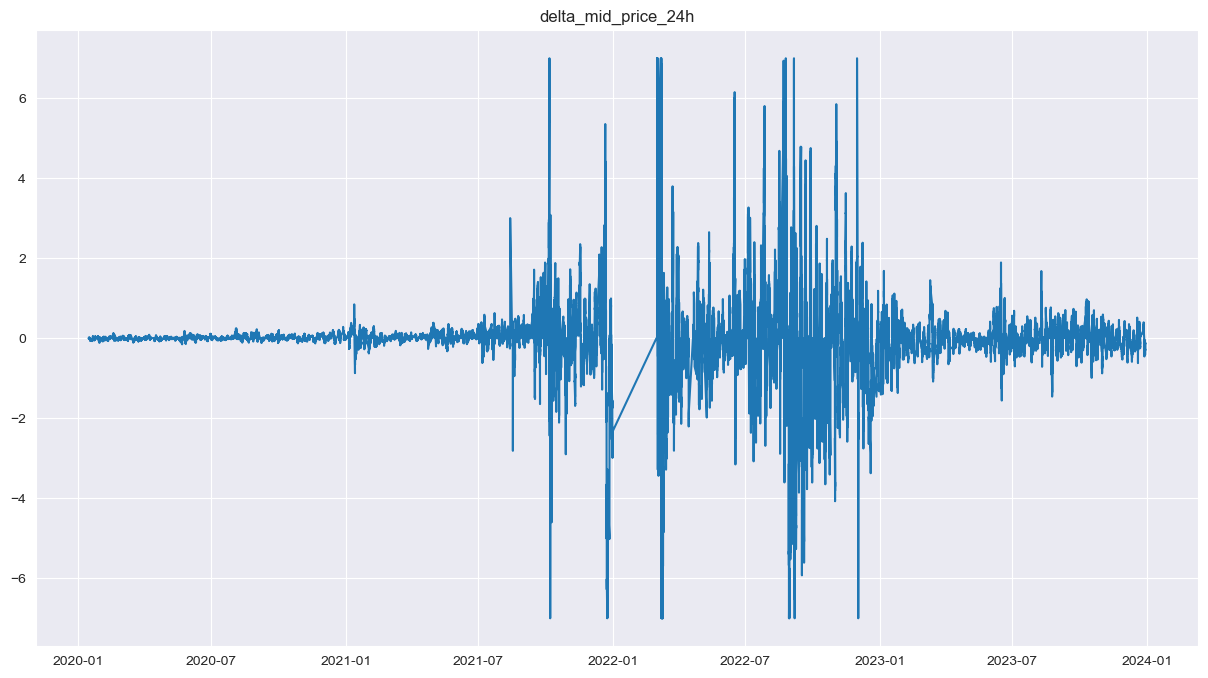

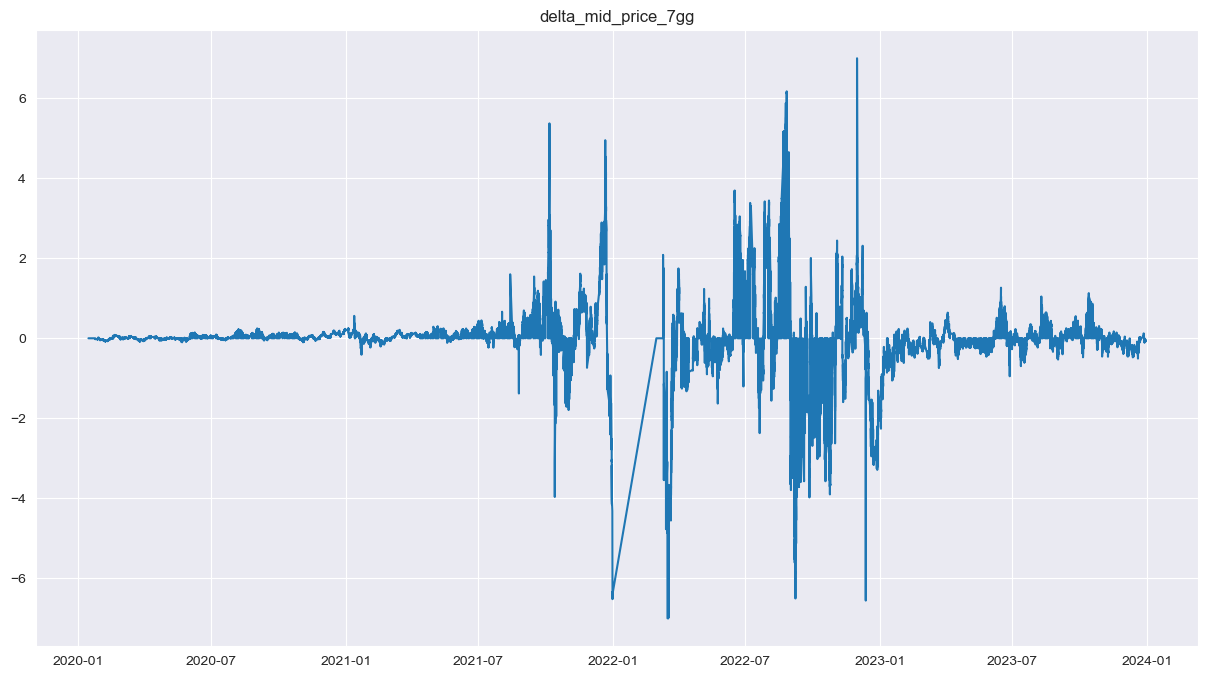

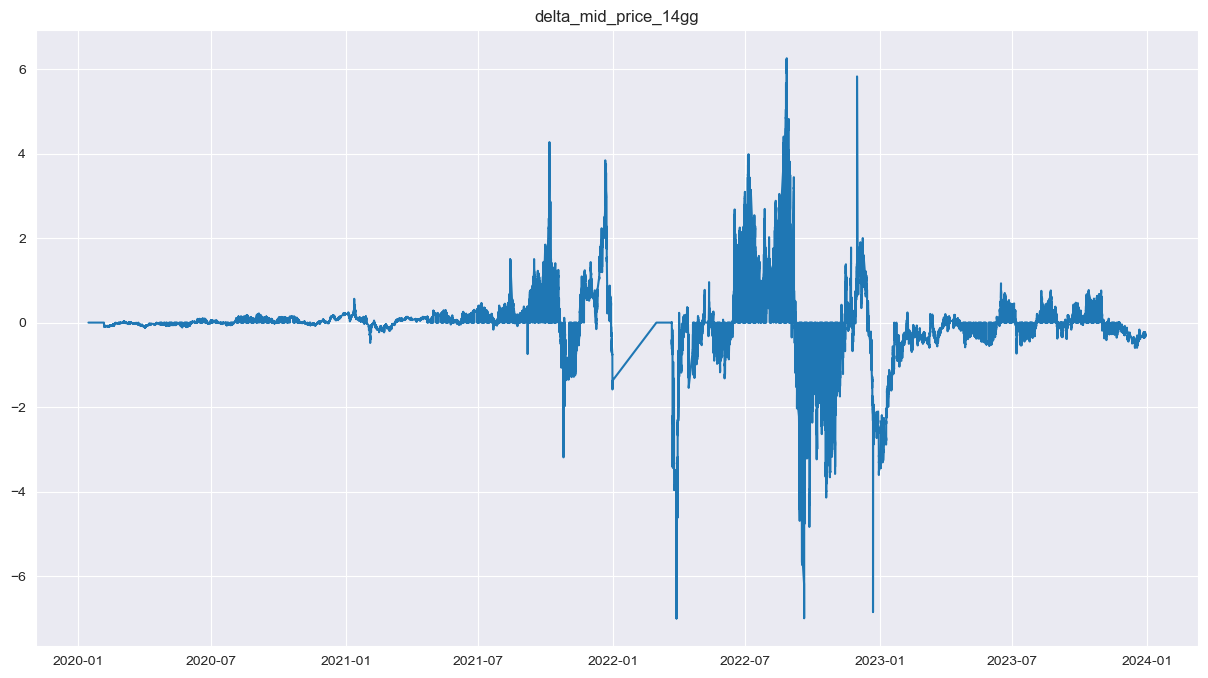

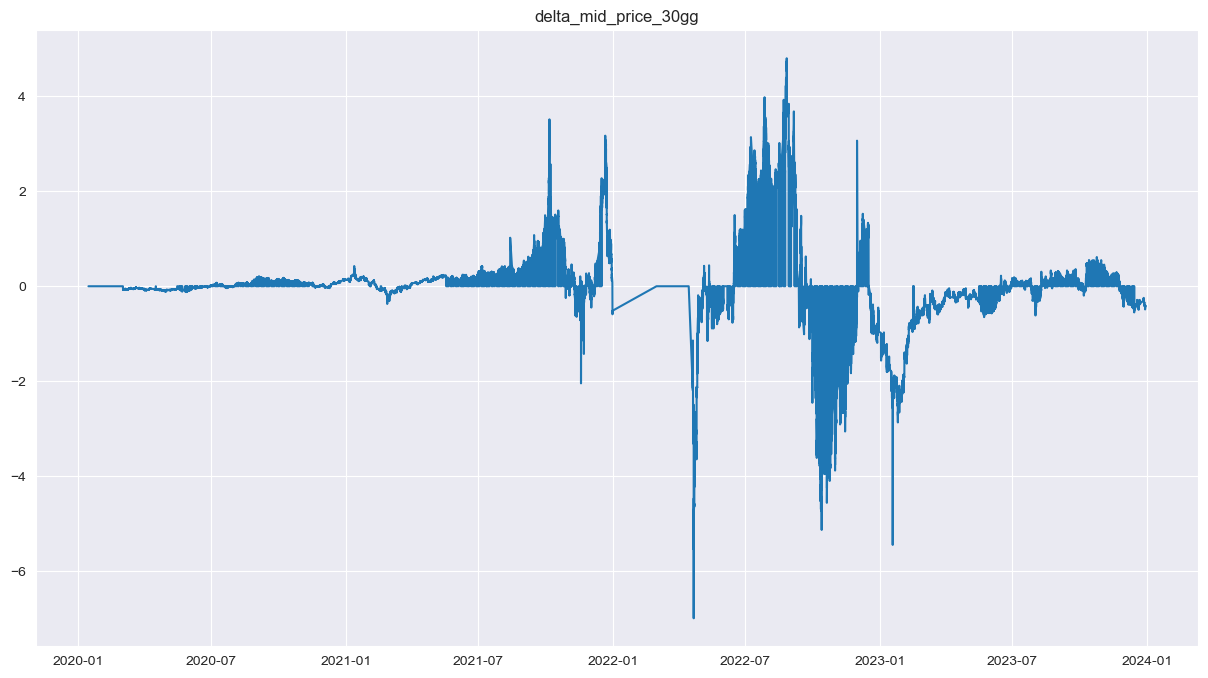

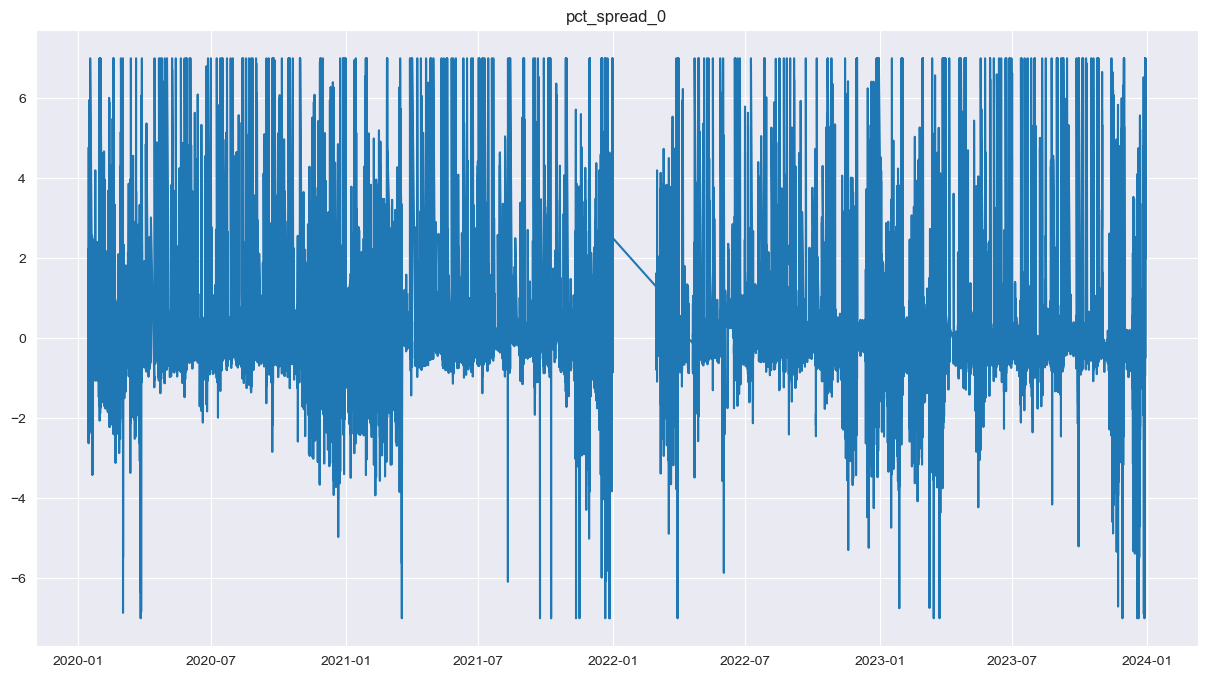

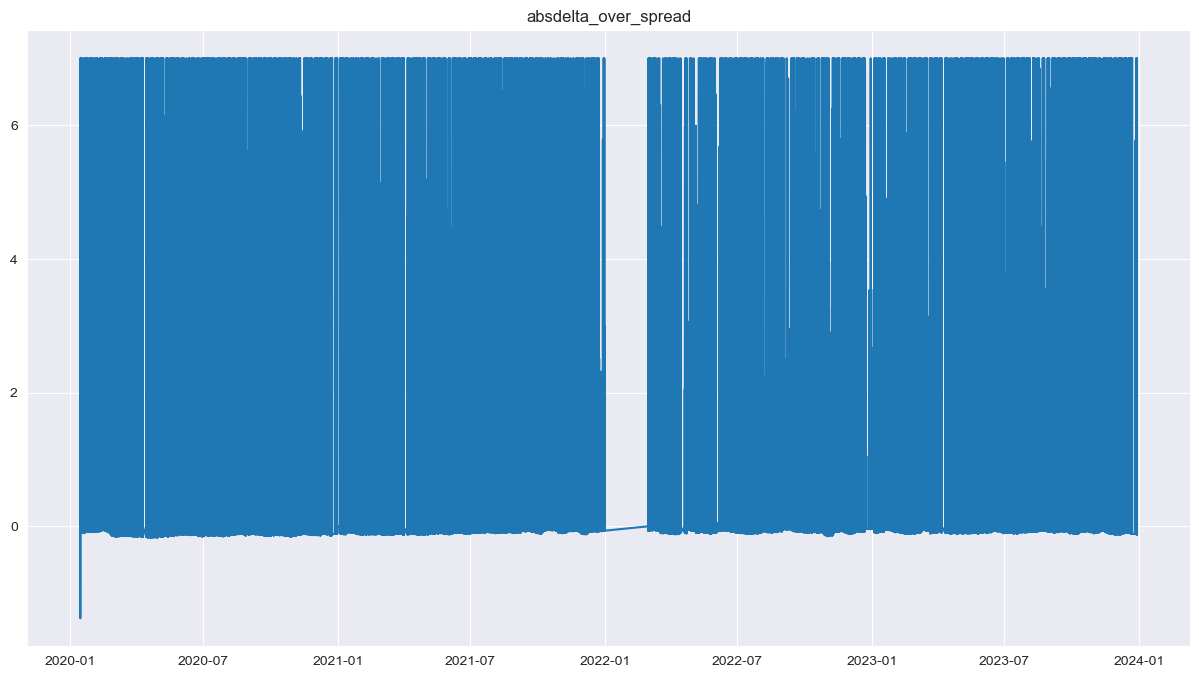

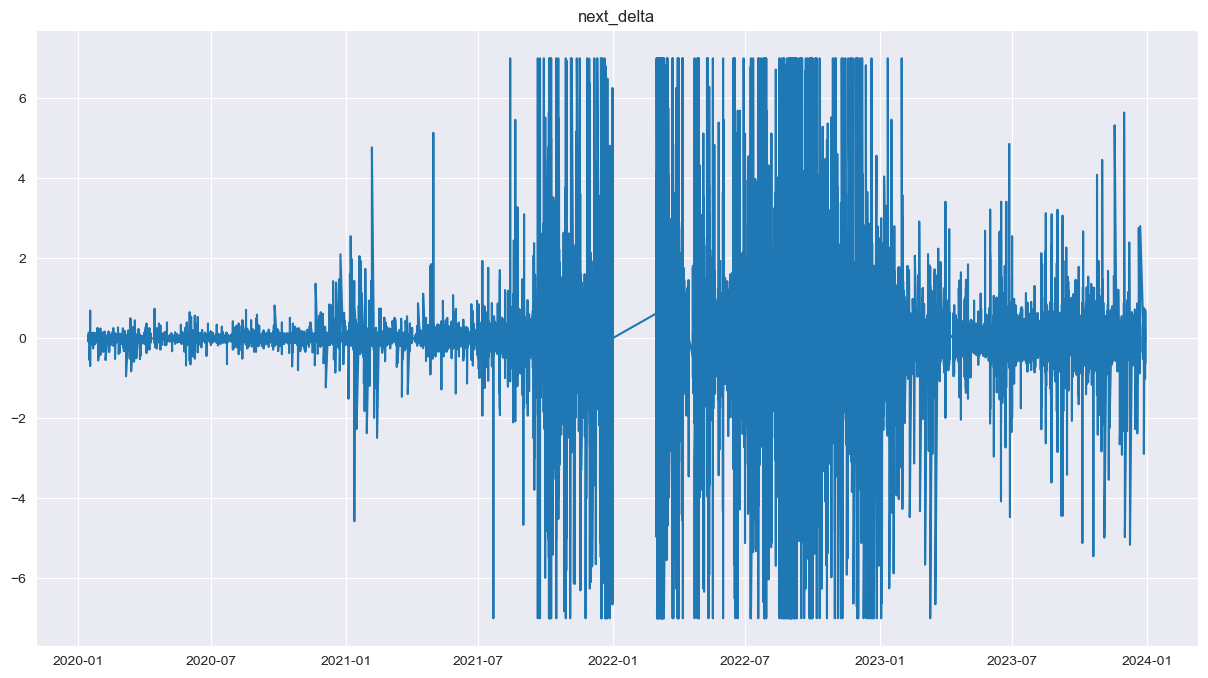

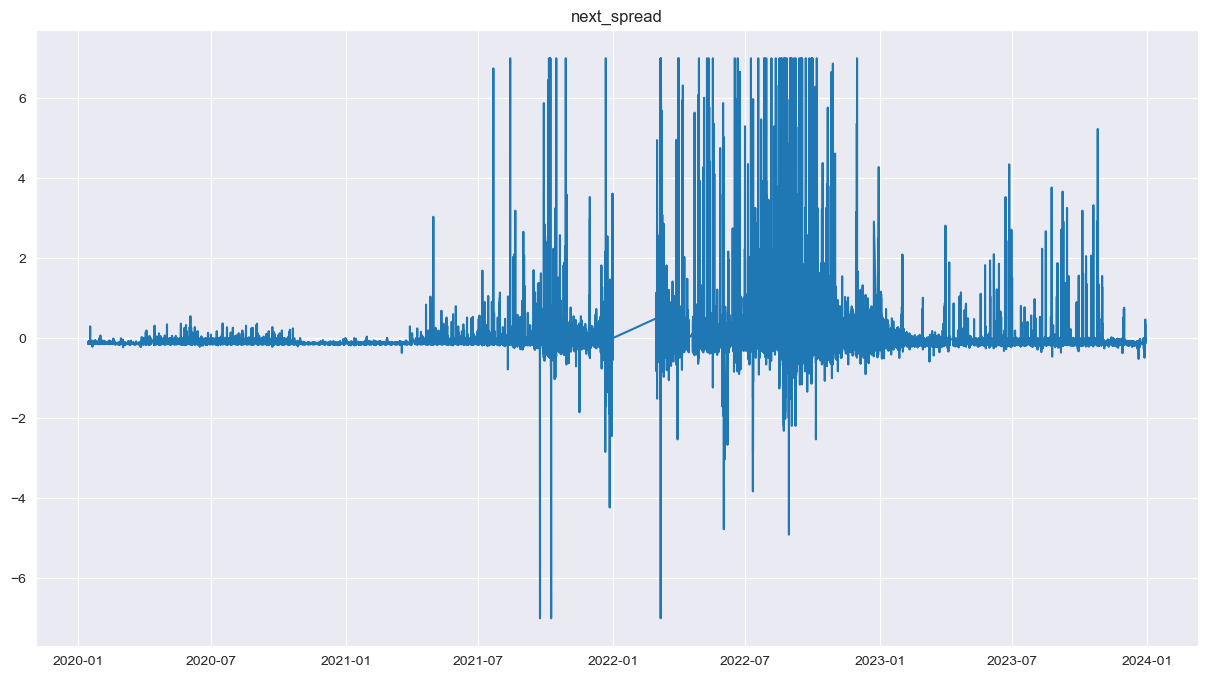

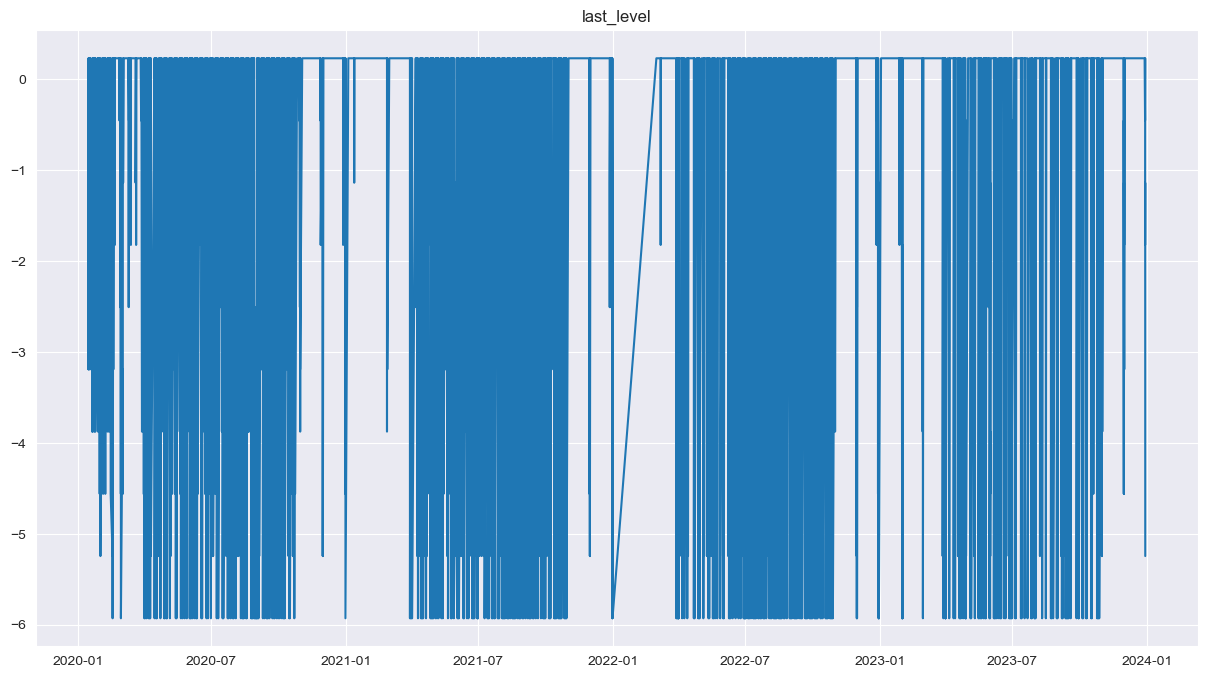

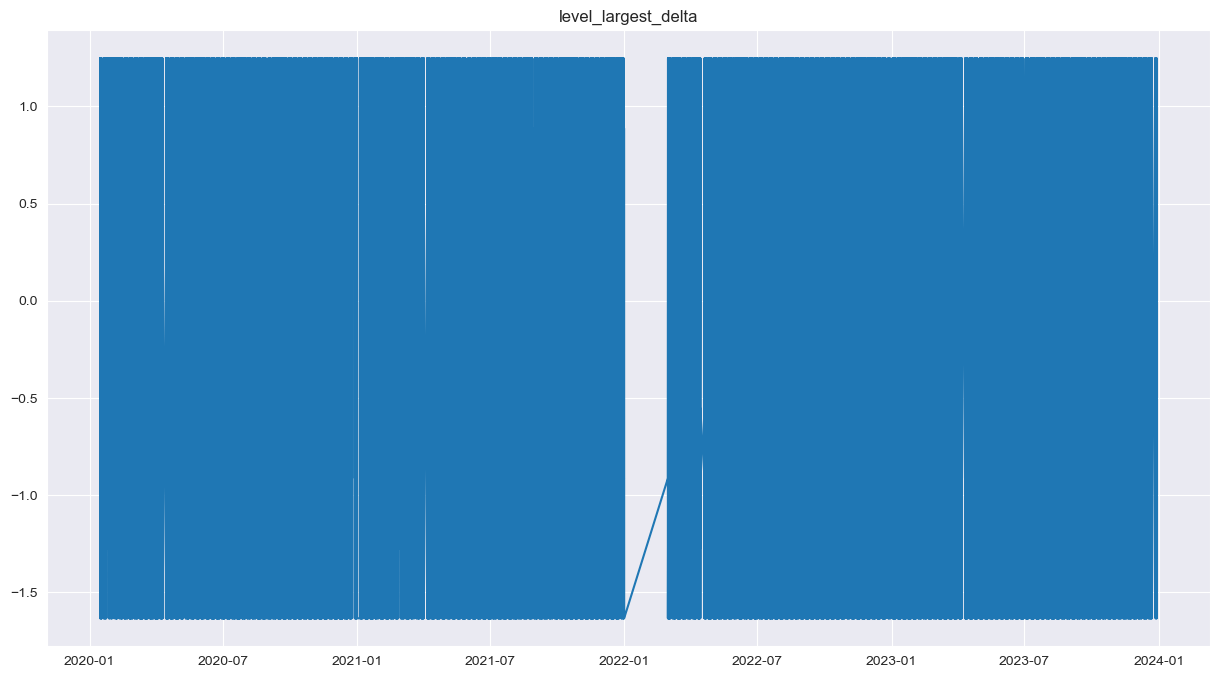

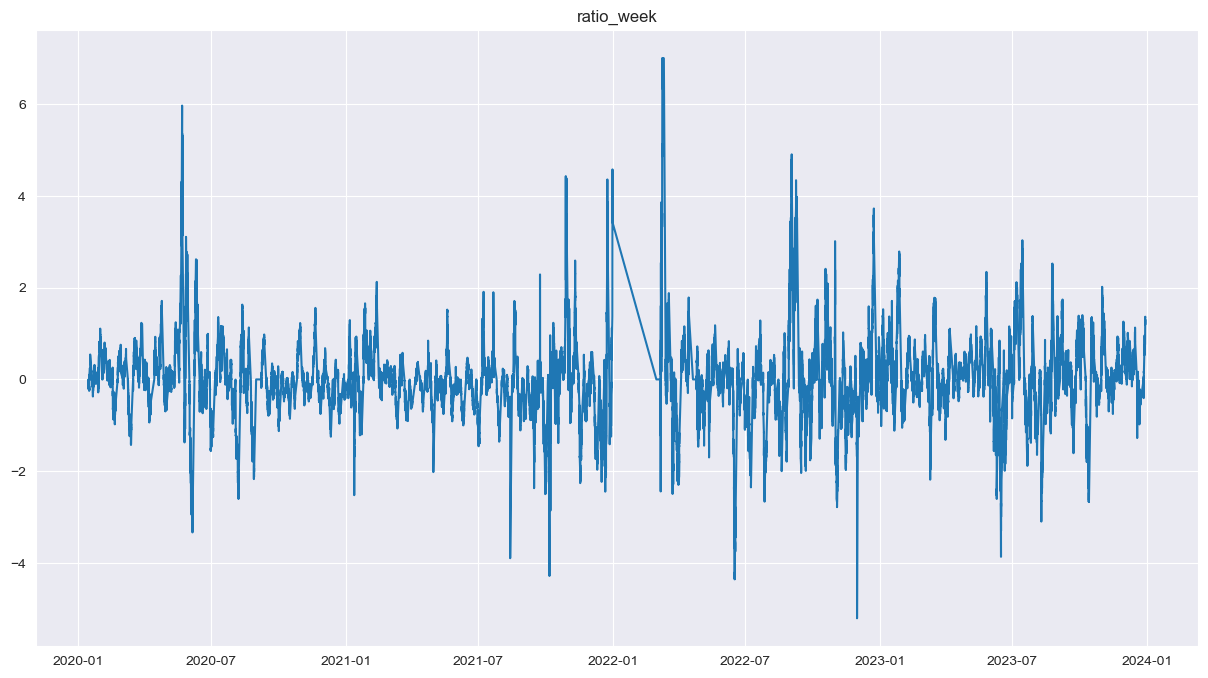

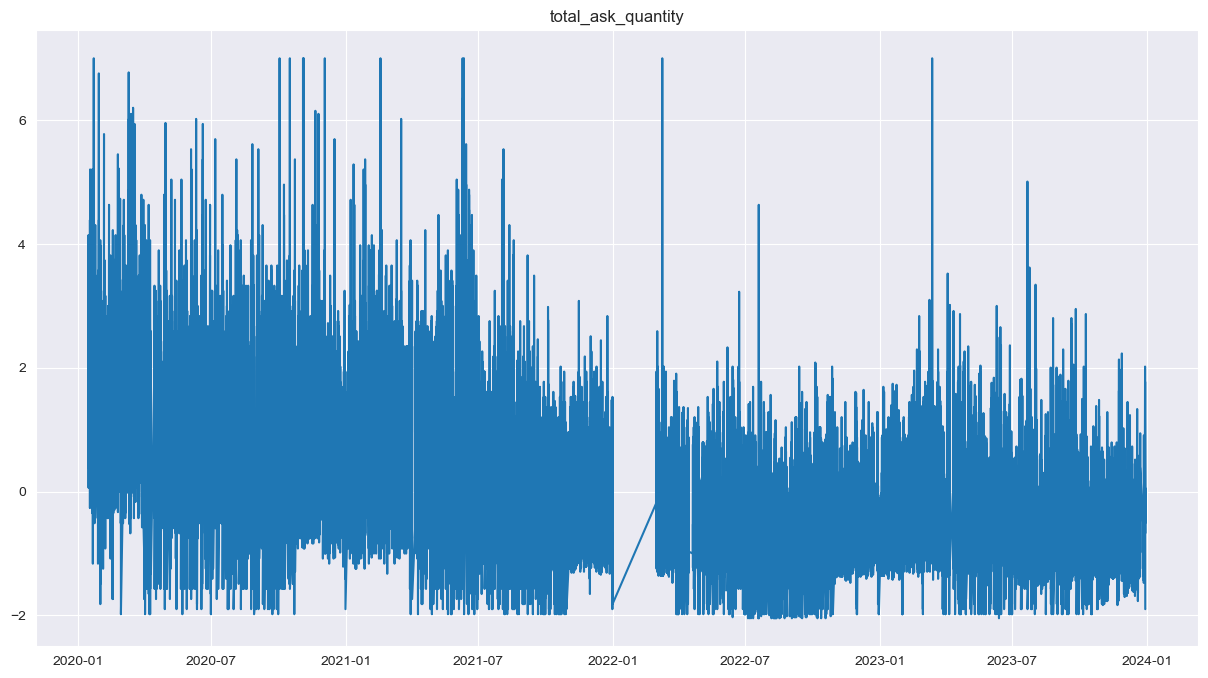

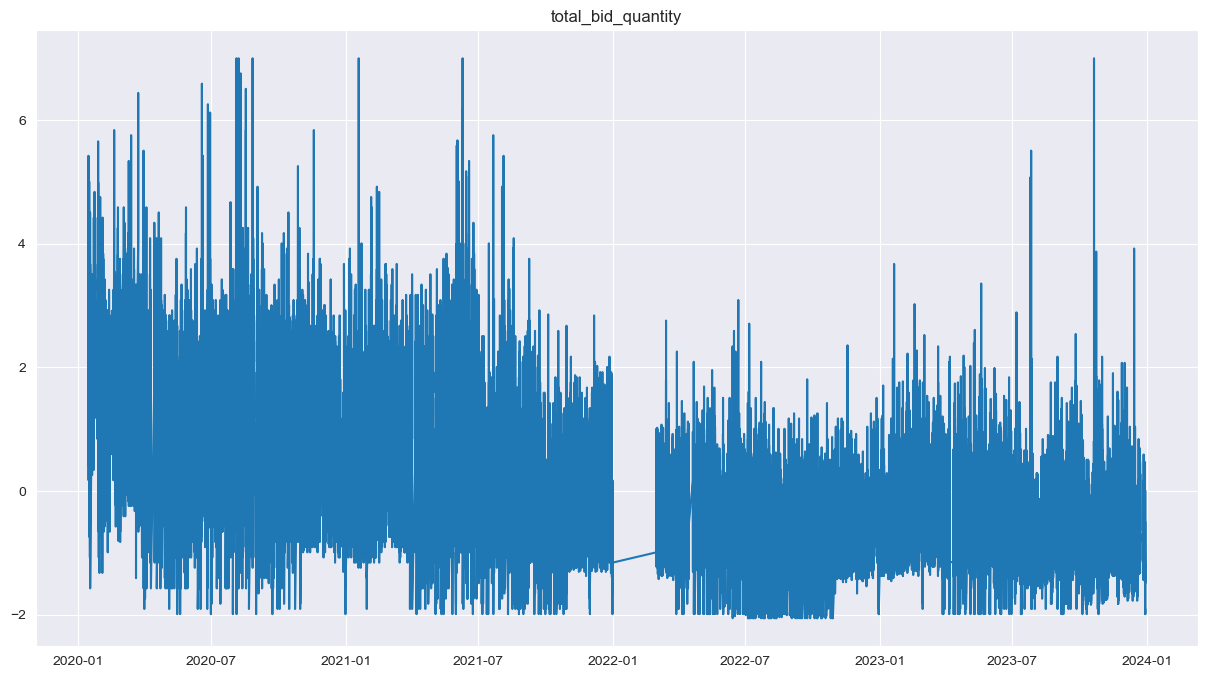

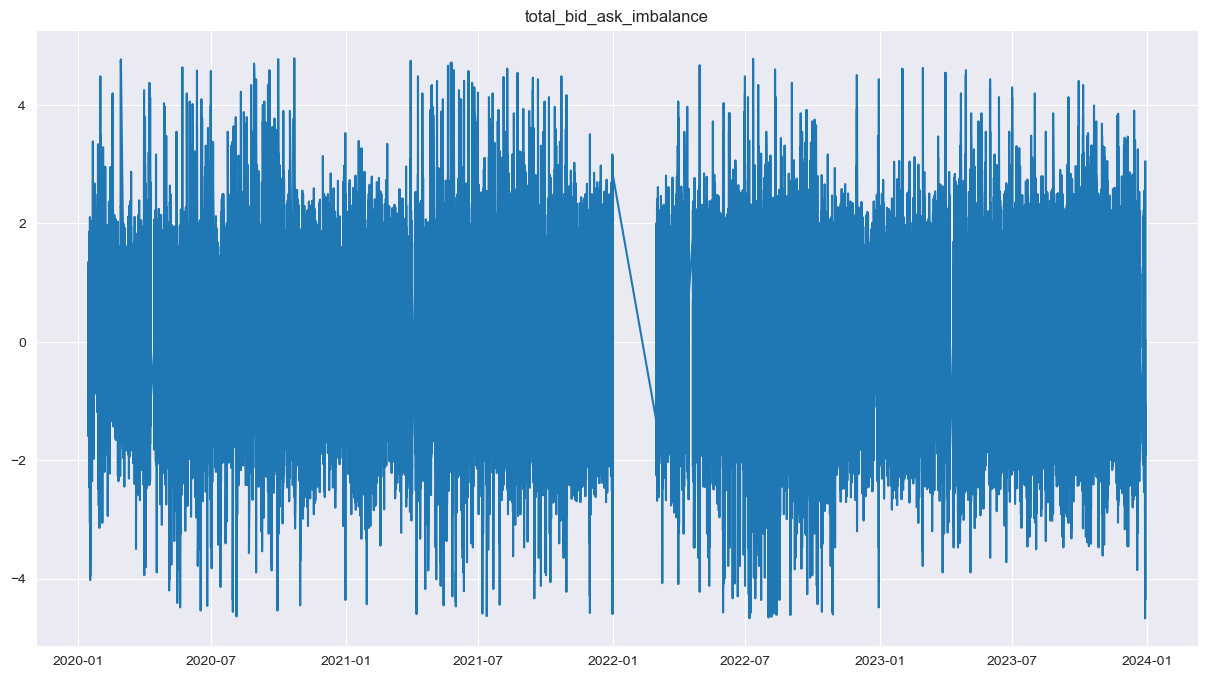

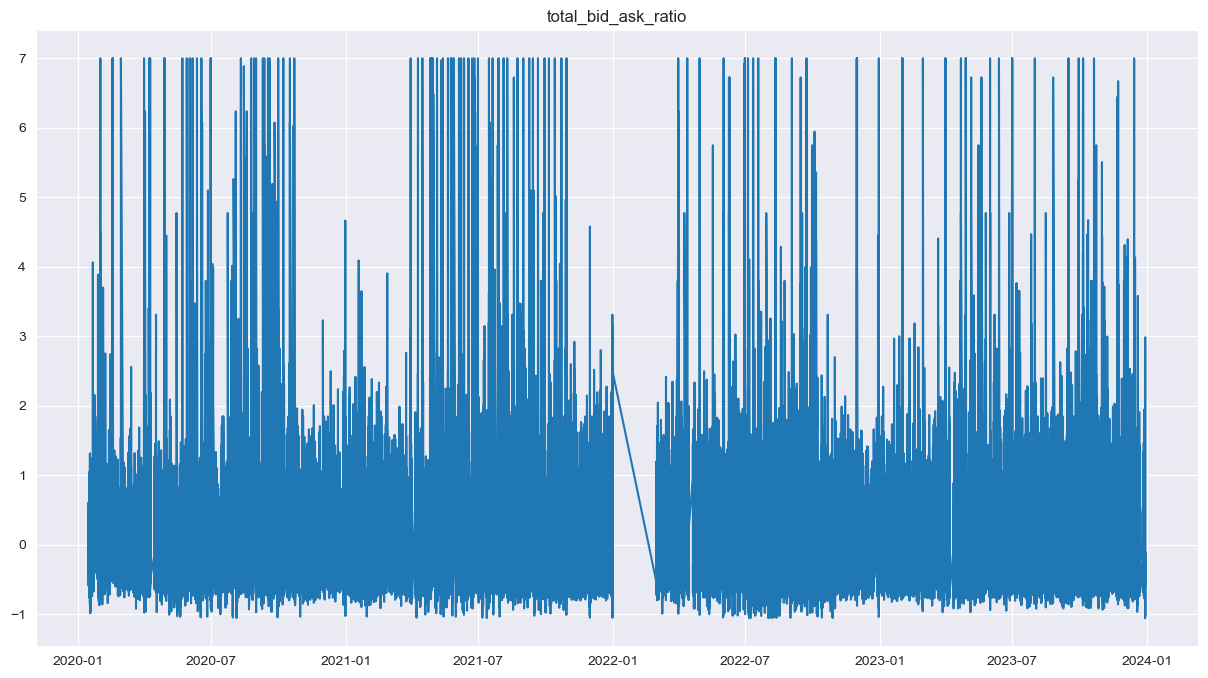

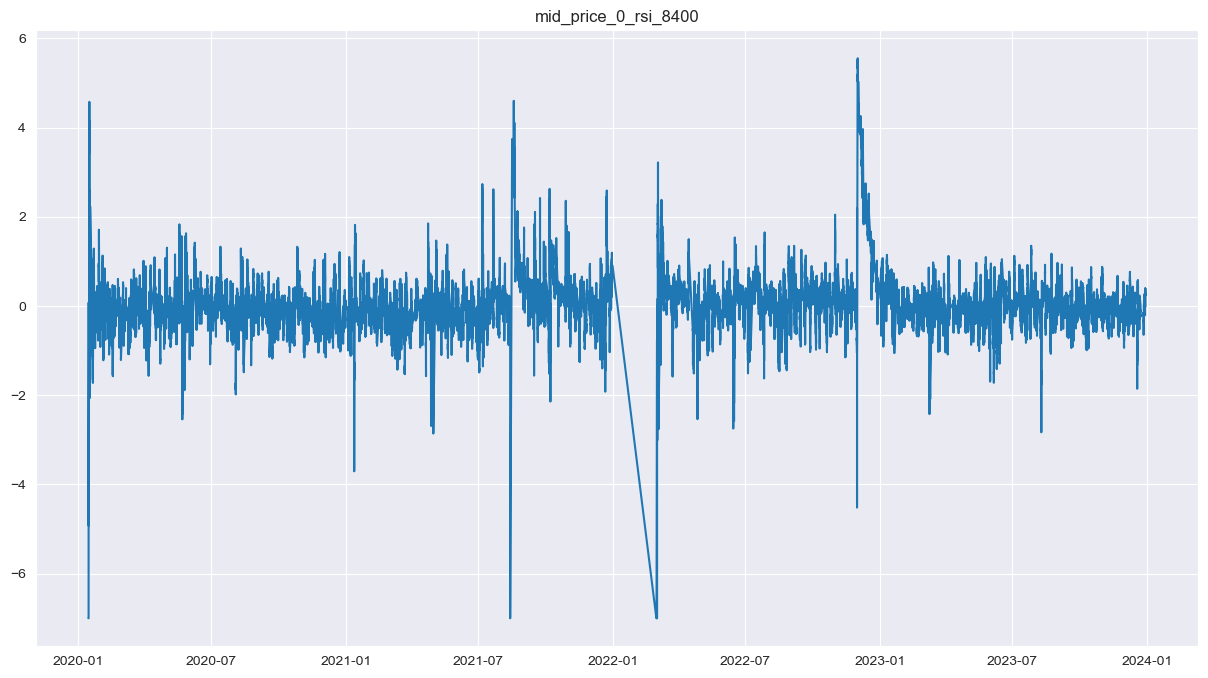

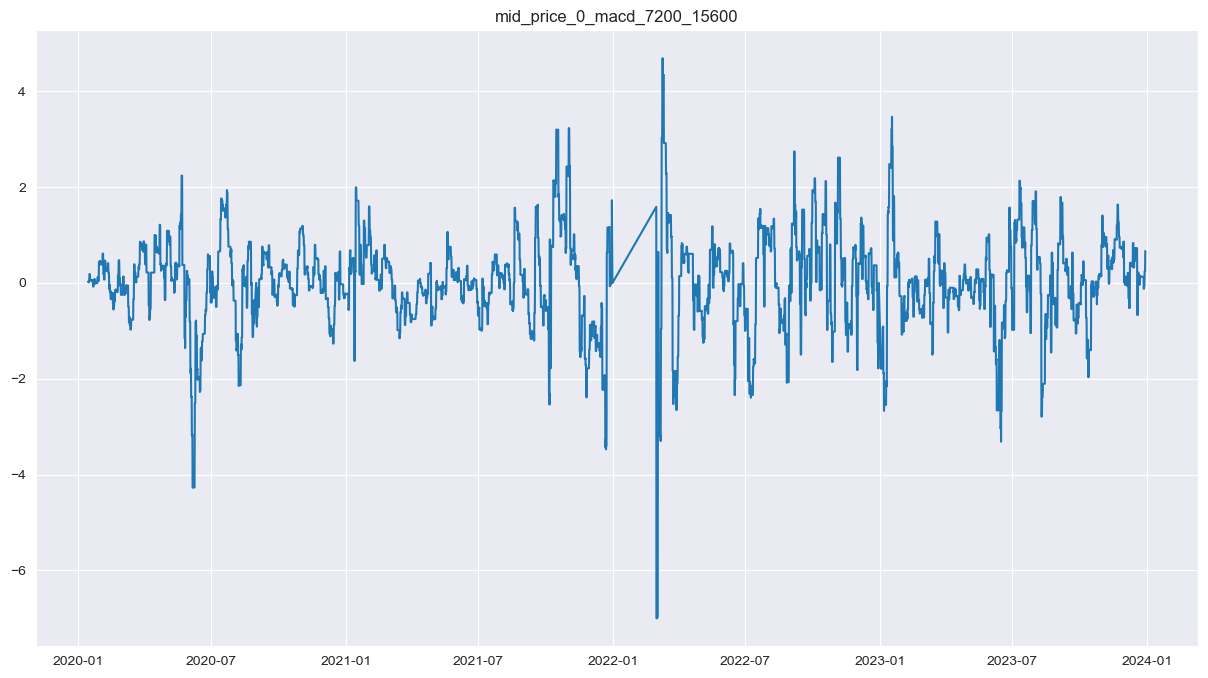

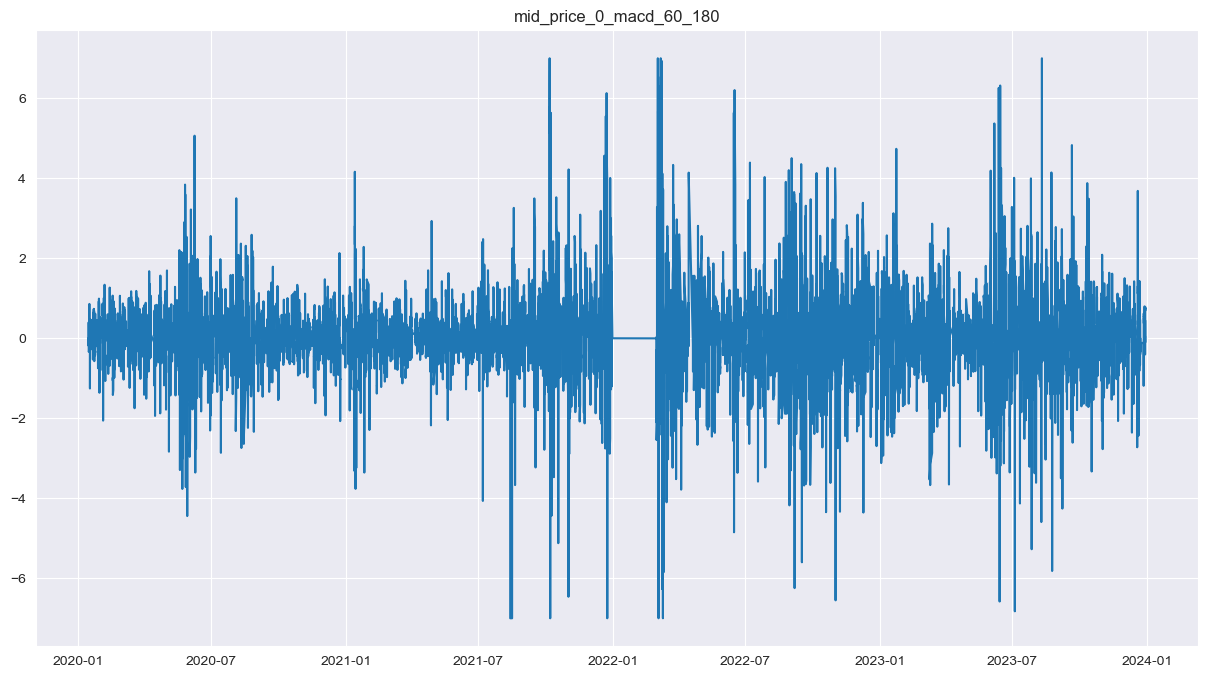

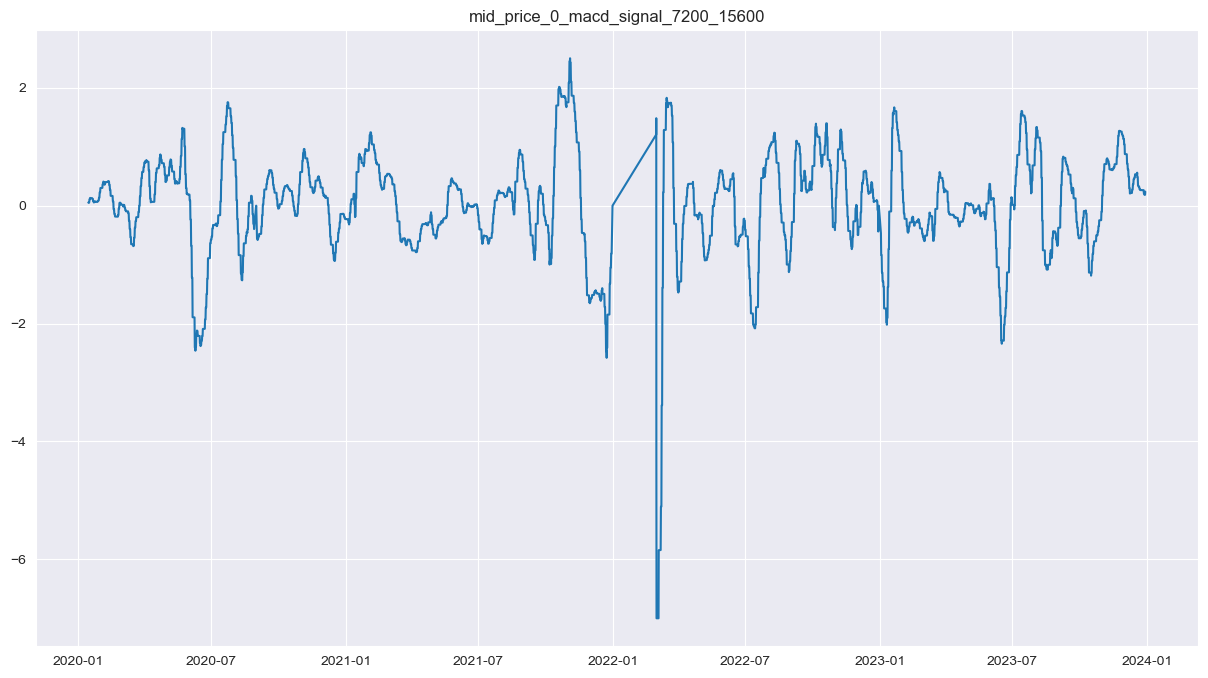

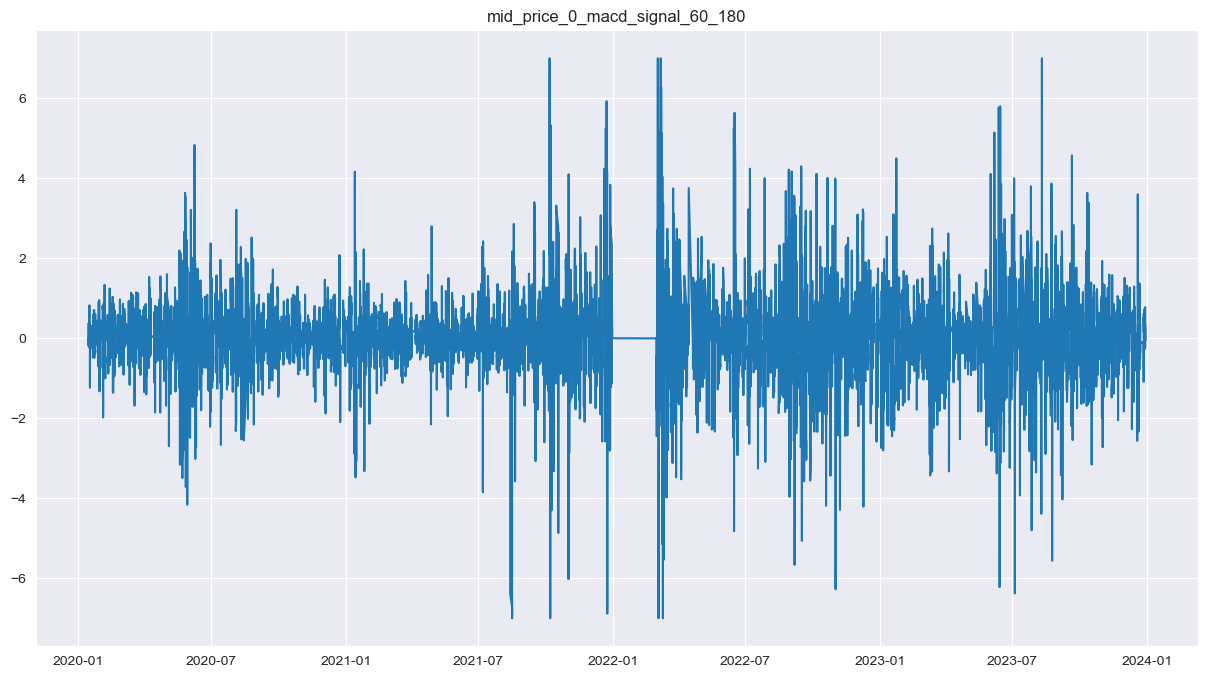

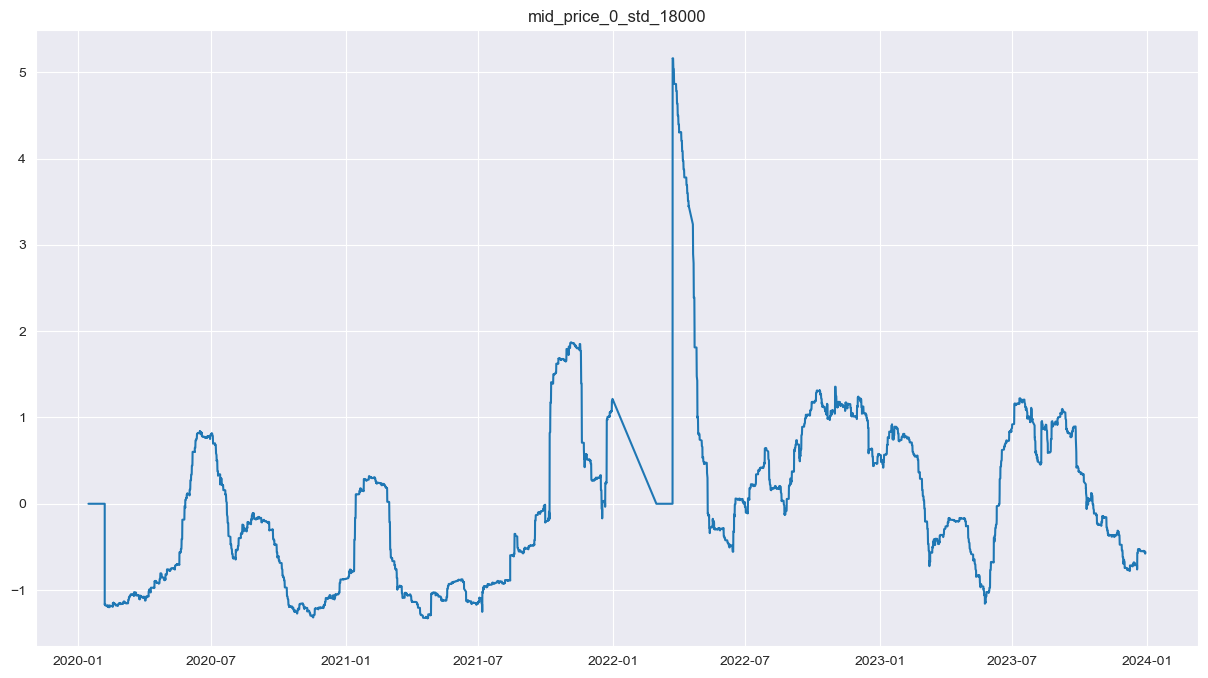

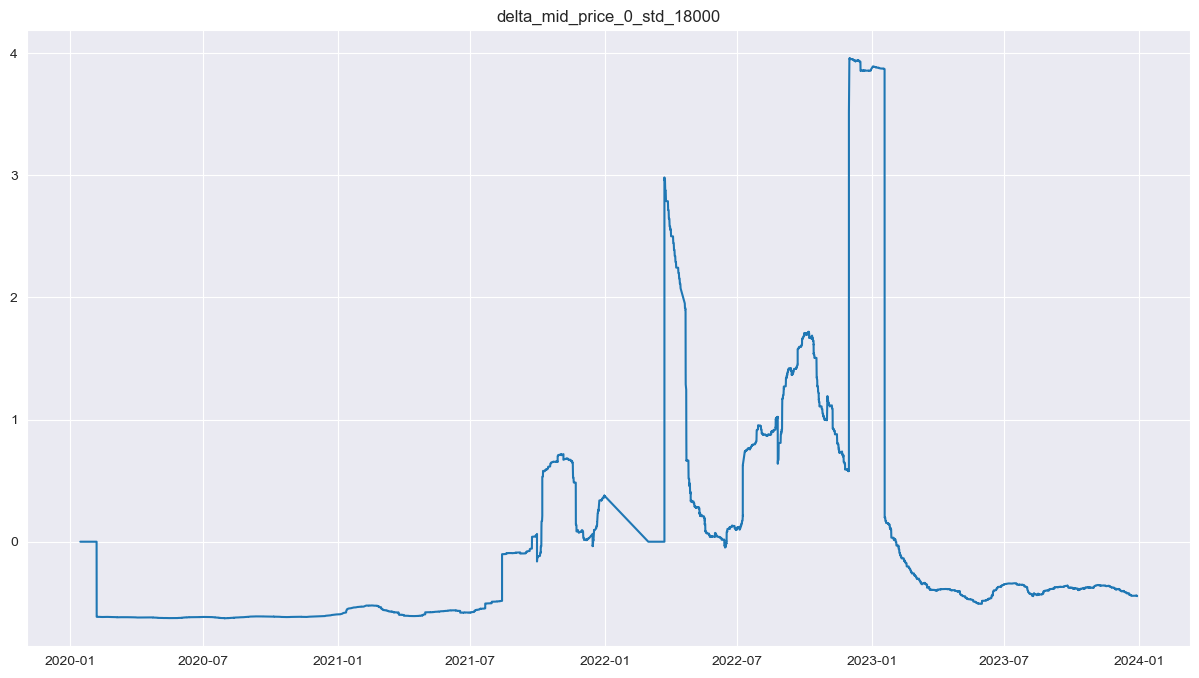

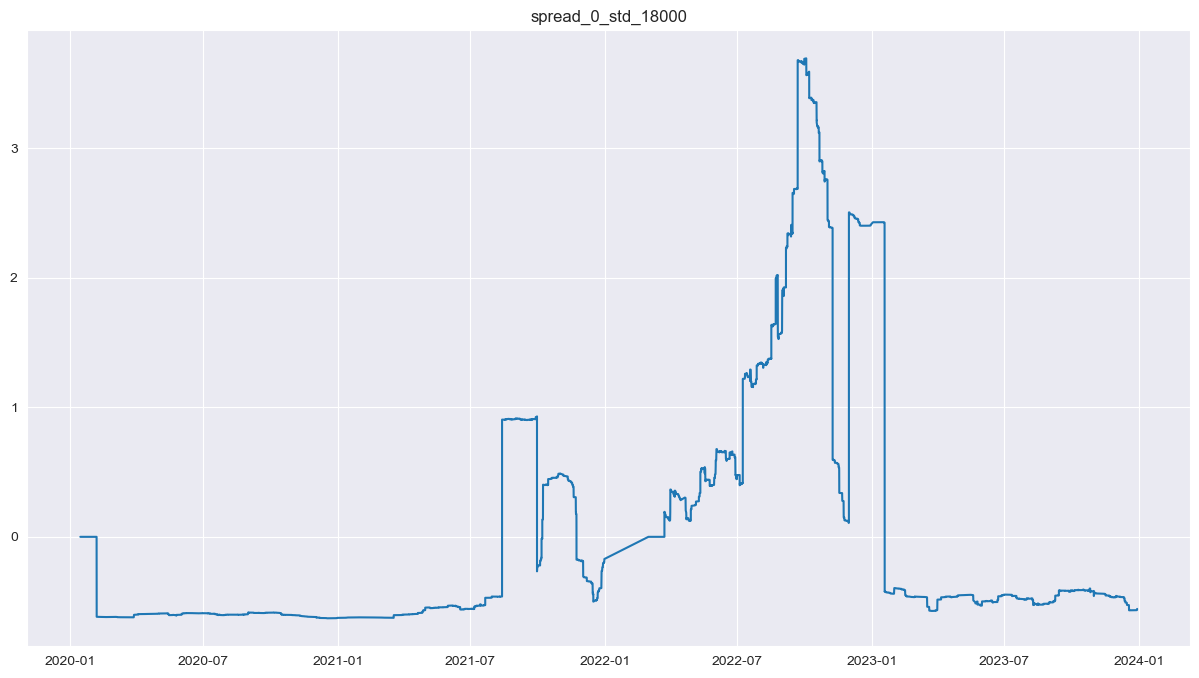

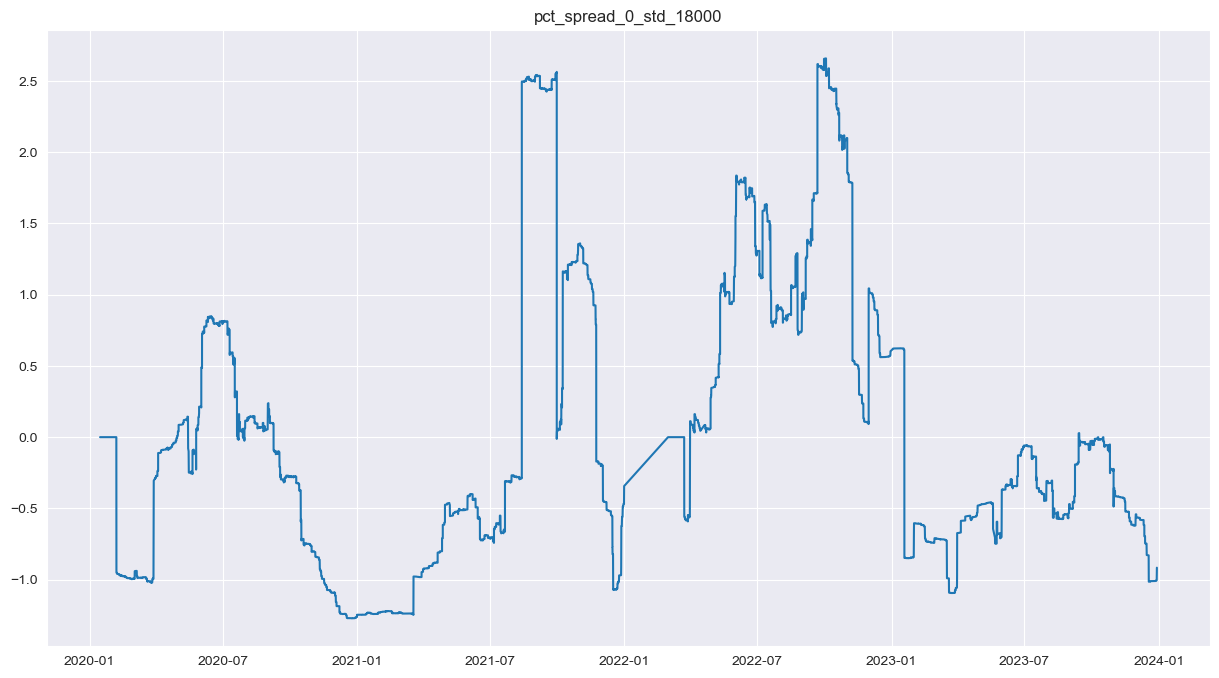

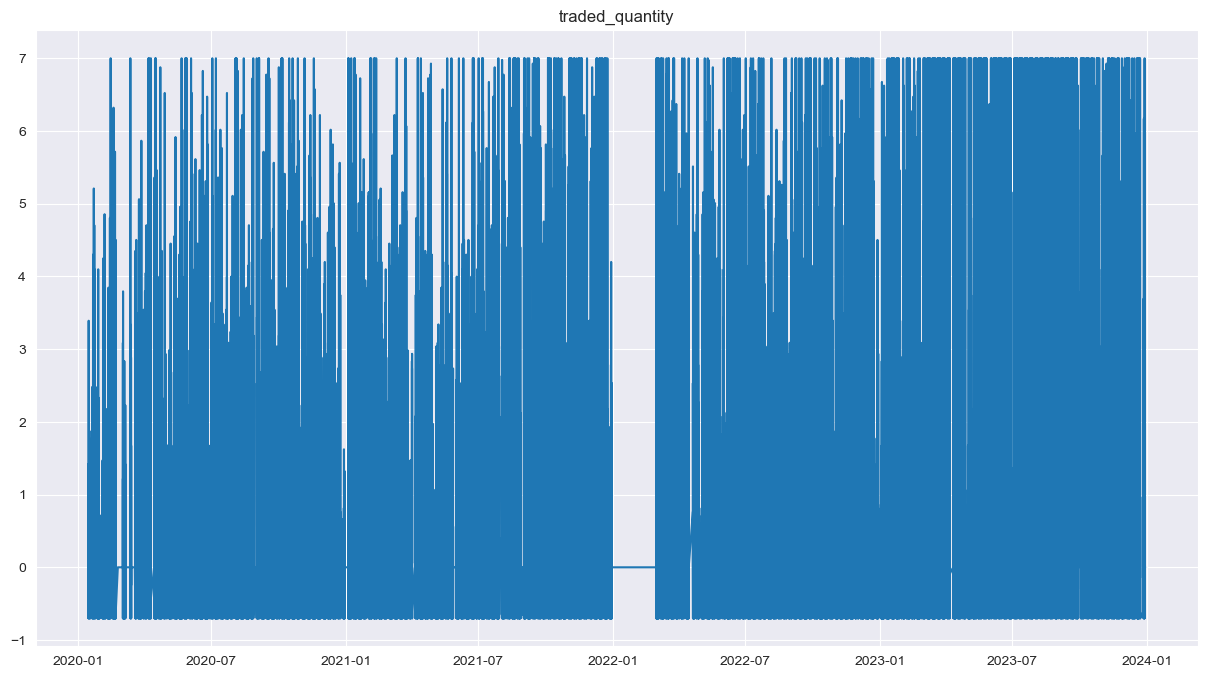

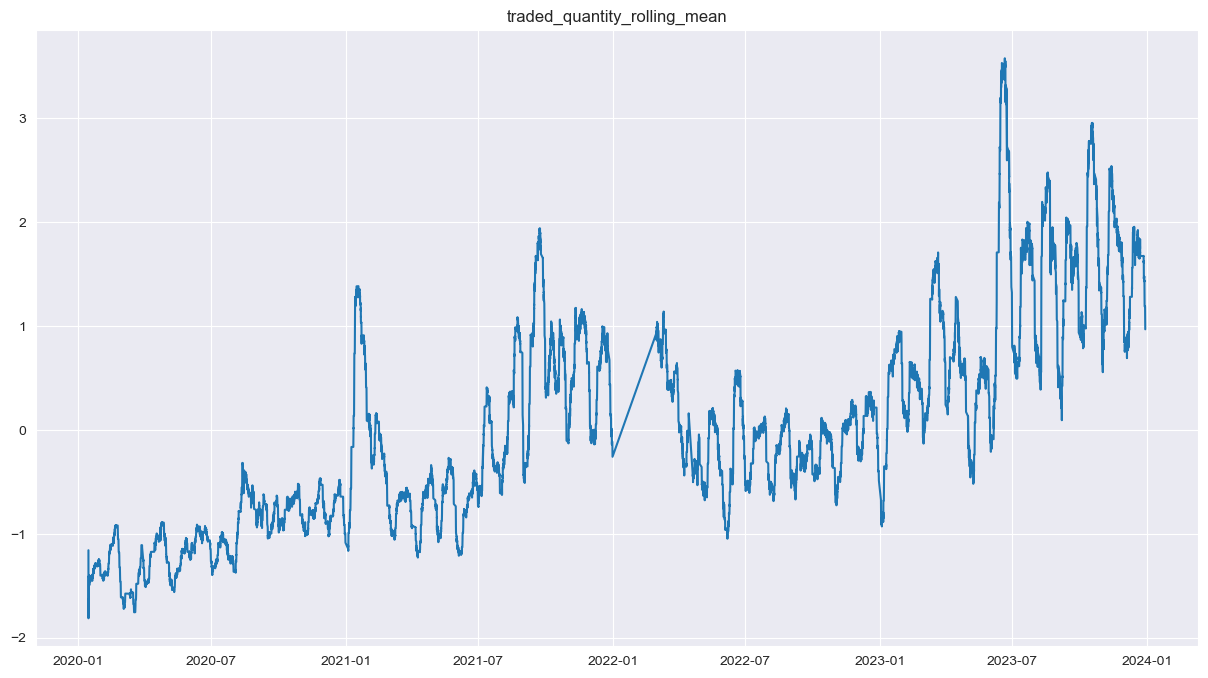

In [4]:
columns = df2.columns

for col in columns:
    plt.figure(figsize=(15,8))
    plt.plot(df['timestamp'], df[col])
    plt.title(col)
    plt.show()

In [ ]:
date = datetime(2020, 1, 16)
df_filtered = df.filter(pl.col('timestamp')<date)
plt.figure(figsize=(15,8))
plt.plot(df_filtered['timestamp'], df_filtered['total_bid_ask_ratio'])
plt.title('total_bid_ask_ratio')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(df_filtered['timestamp'], df_filtered['total_ask_quantity'])
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['mid_price_0_macd_7200_15600'], label='macd', color='blue')
plt.plot(df['timestamp'], df['mid_price_0_macd_signal_7200_15600'], label='signal', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['mid_price_0'])
plt.show()

date = datetime(2020, 1, 22)
plt.figure(figsize=(15, 8))
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0_macd_60_180'], label='macd', color='blue')
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0_macd_signal_60_180'], label='signal', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0_macd_60_180'] - df.filter(pl.col('timestamp')<date)['mid_price_0_macd_signal_60_180'], label='signal', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0'])
plt.show()



In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['timestamp'], df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['mid_price_0_rsi_1800'])
plt.show()
plt.figure(figsize=(15,8))
plt.plot(df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['timestamp'], df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['mid_price_0_rsi_4200'])
plt.show()
plt.figure(figsize=(15,8))
plt.plot(df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['timestamp'], df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['mid_price_0_rsi_8400'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(df['timestamp'], df['mid_price_0'])
plt.show()